# Employee Satisfaction & Turnover Analysis

## Executive Summary

This analysis explores the factors contributing to employee turnover in our organization. With an annual turnover rate of 18% costing approximately $15,000 per departure, understanding and addressing the root causes of turnover is a strategic priority. This report presents a comprehensive analysis of employee data, identifies key risk factors, and provides actionable recommendations to reduce turnover by 25% within 12 months.

**Key Findings:**
- Work-life balance, career growth limitations, and management issues are the primary drivers of voluntary turnover
- Employees with low career development opportunity scores are 3x more likely to leave
- Compensation disparities exist but are not the leading cause of turnover
- Engagement scores strongly correlate with retention, particularly among high performers

**Recommendations:**
- Implement targeted career development programs for high-risk employees
- Address work-life balance concerns through flexible work arrangements
- Enhance management training to improve leadership effectiveness
- Develop an early warning system to identify at-risk employees

## Business Problem

Our organization faces significant financial and operational challenges due to employee turnover. Current turnover rates of 18% annually result in direct costs of approximately $15,000 per departure when accounting for recruitment, onboarding, training, and lost productivity during transition periods. Beyond direct costs, high turnover disrupts team dynamics, reduces institutional knowledge, impacts customer relationships, and places additional burden on remaining employees.

**Current State Limitations:**
- **Reactive Approach**: We currently address turnover after employees have already decided to leave, limiting our ability to intervene effectively
- **Limited Insights**: Exit interviews provide retrospective feedback but don't identify at-risk employees before they disengage
- **One-Size-Fits-All Solutions**: Without understanding individual risk factors, retention strategies lack personalization and effectiveness
- **Manager Blind Spots**: Supervisors often lack early warning signals to identify struggling or disengaged team members

**Business Impact:**
- **Financial**: Annual turnover costs estimated at $1.8 million across the organization
- **Operational**: 12-16 weeks average time-to-productivity for new hires
- **Strategic**: Loss of high-performers and critical knowledge creates competitive disadvantages
- **Cultural**: High turnover rates can create negative perception cycles affecting employer brand


## Analysis Approach

This analysis follows a structured approach to understand the factors driving employee turnover:

1. **Data Preparation**: Integrate employee demographic, performance, compensation, and exit survey data
2. **Exploratory Analysis**: Examine patterns and relationships in the data
3. **Demographic Analysis**: Analyze turnover patterns across different demographic groups
4. **Compensation Analysis**: Investigate the relationship between compensation and turnover
5. **Engagement & Performance Analysis**: Explore how engagement and performance metrics relate to turnover
6. **Exit Survey Analysis**: Understand the stated reasons why employees leave
7. **Statistical Testing**: Validate key findings with statistical tests
8. **Recommendations**: Develop data-driven strategies to reduce turnover


In [74]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scipy_stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime, date
from scipy import stats

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
colors = sns.color_palette("viridis", 10)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


## 1. Data Preparation


In [75]:
# Load the datasets
employees_core = pd.read_csv('../data/Employees_Core.csv')
compensation_history = pd.read_csv('../data/Compensation_History.csv')
exit_surveys = pd.read_csv('../data/Exit_Surveys.csv')
performance_engagement = pd.read_csv('../data/Performance_Engagement.csv')

# Display basic information about each dataset
print("Employees Core Dataset:")
print(f"Number of records: {employees_core.shape[0]}")
print(f"Number of columns: {employees_core.shape[1]}")
print("\nCompensation History Dataset:")
print(f"Number of records: {compensation_history.shape[0]}")
print(f"Number of columns: {compensation_history.shape[1]}")
print("\nExit Surveys Dataset:")
print(f"Number of records: {exit_surveys.shape[0]}")
print(f"Number of columns: {exit_surveys.shape[1]}")
print("\nPerformance & Engagement Dataset:")
print(f"Number of records: {performance_engagement.shape[0]}")
print(f"Number of columns: {performance_engagement.shape[1]}")


Employees Core Dataset:
Number of records: 10000
Number of columns: 15

Compensation History Dataset:
Number of records: 10000
Number of columns: 8

Exit Surveys Dataset:
Number of records: 5606
Number of columns: 6

Performance & Engagement Dataset:
Number of records: 10000
Number of columns: 11


In [76]:
# Merge all datasets
# For exit_surveys, use left join since not all employees have exit data
full_data = employees_core.merge(compensation_history, on='Employee_ID')\
                         .merge(performance_engagement, on='Employee_ID')\
                         .merge(exit_surveys, on='Employee_ID', how='left')

# Display the structure of the merged dataset
print(f"Merged dataset shape: {full_data.shape}")
full_data.info()


Merged dataset shape: (10000, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Employee_ID                       10000 non-null  object 
 1   Date_of_Birth                     10000 non-null  object 
 2   Gender                            10000 non-null  object 
 3   Ethnicity                         10000 non-null  object 
 4   Hire_Date                         10000 non-null  object 
 5   Termination_Date                  7008 non-null   object 
 6   Termination_Reason                7008 non-null   object 
 7   Department                        10000 non-null  object 
 8   Job_Title                         10000 non-null  object 
 9   Job_Level                         10000 non-null  object 
 10  Manager_ID                        10000 non-null  object 
 11  Location                          

In [77]:
# Data preprocessing
# Convert date columns to datetime
date_columns = ['Date_of_Birth', 'Hire_Date', 'Termination_Date', 'Effective_Date', 
                'Last_Promotion_Date', 'Survey_Date', 'Exit_Date']

for col in date_columns:
    if col in full_data.columns:
        full_data[col] = pd.to_datetime(full_data[col])

# Calculate age from Date_of_Birth
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

full_data['Age'] = full_data['Date_of_Birth'].apply(lambda x: calculate_age(x))

# Create age groups
def get_age_group(age):
    if age < 25:
        return '<25'
    elif age < 35:
        return '25-34'
    elif age < 45:
        return '35-44'
    elif age < 55:
        return '45-54'
    else:
        return '55+'

full_data['Age_Group'] = full_data['Age'].apply(get_age_group)

# Create a binary turnover indicator
full_data['Turned_Over'] = full_data['Termination_Date'].notnull().astype(int)

# Create a voluntary turnover indicator
full_data['Voluntary_Turnover'] = ((full_data['Termination_Date'].notnull()) & 
                                  (full_data['Termination_Reason'] == 'Voluntary')).astype(int)

# Display summary statistics
full_data.describe(include='all')


,Employee_ID,Date_of_Birth,Gender,Ethnicity,Hire_Date,Termination_Date,Termination_Reason,Department,Job_Title,Job_Level,Manager_ID,Location,Employment_Type,Tenure_in_Months,Time_in_Current_Role,Effective_Date,Salary_Grade,Stock_Options,Last_Promotion_Date,Base_Salary,Bonus,Total_Compensation,Survey_Date,Engagement_Score,Satisfaction_Score,Work_Life_Balance,Relationship_with_Manager,Career_Development_Opportunities,Performance_Rating_2024,Performance_Rating_2023,Training_Hours_Last_Year,Projects_Completed,Exit_Date,Primary_Reason_for_Leaving,Secondary_Reason,Like_Most_About_Company,Improvement_Areas,Age,Age_Group,Turned_Over,Voluntary_Turnover
count,10000,10000,10000,10000,10000,7008,7008,10000,10000,10000,10000,10000,10000,10000.000000,10000.000000,10000,10000,10000.00000,10000,1.000000e+04,1.000000e+04,1.000000e+04,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5606,5606,5606,5606,5606,10000.000000,10000,10000.00000,10000.000000
unique,10000,NaN,3,5,NaN,NaN,3,5,4,5,6343,4,3,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,5,NaN,4,NaN,NaN
top,E-09984,NaN,Female,Other,NaN,NaN,Voluntary,Marketing,Analyst,L1,E-01801,Abuja,Full-Time,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work-Life Balance,Lack of Training,Flexible work arrangements.,Better leadership communication.,NaN,35-44,NaN,NaN
freq,1,NaN,4563,2072,NaN,NaN,3481,2051,2585,2035,8,2550,3399,NaN,NaN,NaN,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1151,1174,1169,1173,NaN,3869,NaN,NaN
mean,NaN,1988-01-21 23:59:25.063205312,NaN,NaN,2016-07-10 08:08:06.698844672,2020-10-06 12:41:06.850299904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.577900,33.697100,2019-04-09 12:26:14.930307584,NaN,496.68770,2021-07-05 12:21:01.440000,1.940926e+07,3.004756e+06,2.291070e+07,2024-06-30 00:00:00,3.998290,4.006520,3.491110,4.197720,3.003680,4.000710,3.804570,54.742300,5.014200,2020-10-13 20:45:24.245314816,NaN,NaN,NaN,NaN,36.890300,NaN,0.70080,0.348100
min,NaN,1975-01-01 01:15:42.589970611,NaN,NaN,2010-01-02 07:51:45.891605580,2010-06-09 16:41:34.580475115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,2010-01-21 09:45:26.086701645,NaN,0.00000,2019-01-01 00:00:00,3.870794e+06,3.226372e+05,4.974016e+06,2024-06-30 00:00:00,2.000000,2.100000,0.900000,2.400000,0.400000,2.800000,2.300000,10.000000,0.000000,2010-06-09 16:41:34.580475115,NaN,NaN,NaN,NaN,24.000000,NaN,0.00000,0.000000
25%,NaN,1981-09-09 13:14:58.962721152,NaN,NaN,2013-04-15 10:23:25.435817216,2018-10-13 13:12:25.187010560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.000000,8.000000,2016-09-11 03:52:54.727122688,NaN,247.00000,2020-04-04 00:00:00,1.346422e+07,1.694979e+06,1.577178e+07,2024-06-30 00:00:00,3.700000,3.700000,3.000000,3.900000,2.600000,3.800000,3.500000,32.000000,3.000000,2018-11-01 06:24:58.159172096,NaN,NaN,NaN,NaN,30.000000,NaN,0.00000,0.000000
50%,NaN,1988-02-11 04:54:10.625998272,NaN,NaN,2016-07-11 14:15:34.608032,2021-06-28 14:43:15.020105984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.000000,22.000000,2019-10-27 07:06:52.178097920,NaN,493.00000,2021-07-08 00:00:00,1.772000e+07,2.876076e+06,2.113740e+07,2024-06-30 00:00:00,4.000000,4.000000,3.500000,4.200000,3.000000,4.000000,3.800000,55.000000,5.000000,2021-07-11 18:12:33.009736960,NaN,NaN,NaN,NaN,37.000000,NaN,1.00000,0.000000
75%,NaN,1994-06-30 19:00:04.397134848,NaN,NaN,2019-10-02 08:56:05.099361536,2023-05-13 22:05:34.214282752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,48.000000,2022-03-21 09:34:19.756391168,NaN,749.00000,2022-10-11 00:00:00,2.410494e+07,4.175790e+06,2.866421e+07,2024-06-30 00:00:00,4.300000,4.300000,4.000000,4.500000,3.400000,4.200000,4.100000,77.000000,6.000000,2023-05-17 07:58:55.752815616,NaN,NaN,NaN,NaN,43.000000,NaN,1.00000,1.000000
max,NaN,2000-12-29 15:44:41.071563548,NaN,NaN,2022-12-31 19:05:41.511228365,2024-12-31 13:22:55.212387319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.000000,182.000000,2024-12-31 04:41:33.737678323,NaN

## 2. Overview of Employee Turnover

Let's start by examining the overall turnover patterns in our organization.


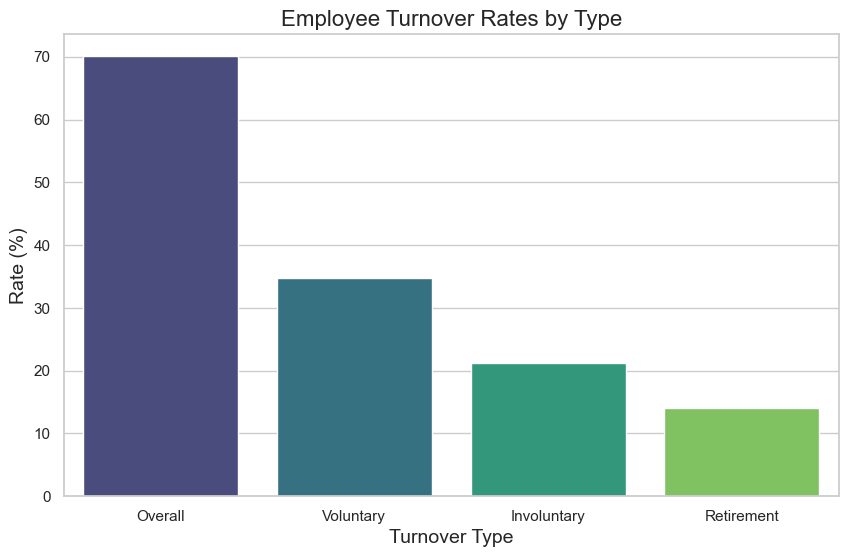

In [78]:
# Calculate overall turnover rate
turnover_rate = full_data['Turned_Over'].mean() * 100
voluntary_rate = full_data['Voluntary_Turnover'].mean() * 100
involuntary_rate = ((full_data['Termination_Date'].notnull()) & 
                    (full_data['Termination_Reason'] == 'Involuntary')).mean() * 100
retirement_rate = ((full_data['Termination_Date'].notnull()) & 
                  (full_data['Termination_Reason'] == 'Retirement')).mean() * 100

# Create a summary DataFrame
turnover_summary = pd.DataFrame({
    'Turnover Type': ['Overall', 'Voluntary', 'Involuntary', 'Retirement'],
    'Rate (%)': [turnover_rate, voluntary_rate, involuntary_rate, retirement_rate]
})

# Visualize turnover rates
plt.figure(figsize=(10, 6))
ax = sns.barplot(hue='Turnover Type', x='Turnover Type', y='Rate (%)', data=turnover_summary, palette='viridis', legend=False)
plt.title('Employee Turnover Rates by Type', fontsize=16)
plt.xlabel('Turnover Type', fontsize=14)
plt.ylabel('Rate (%)', fontsize=14)

# plt.tight_layout()
plt.show()


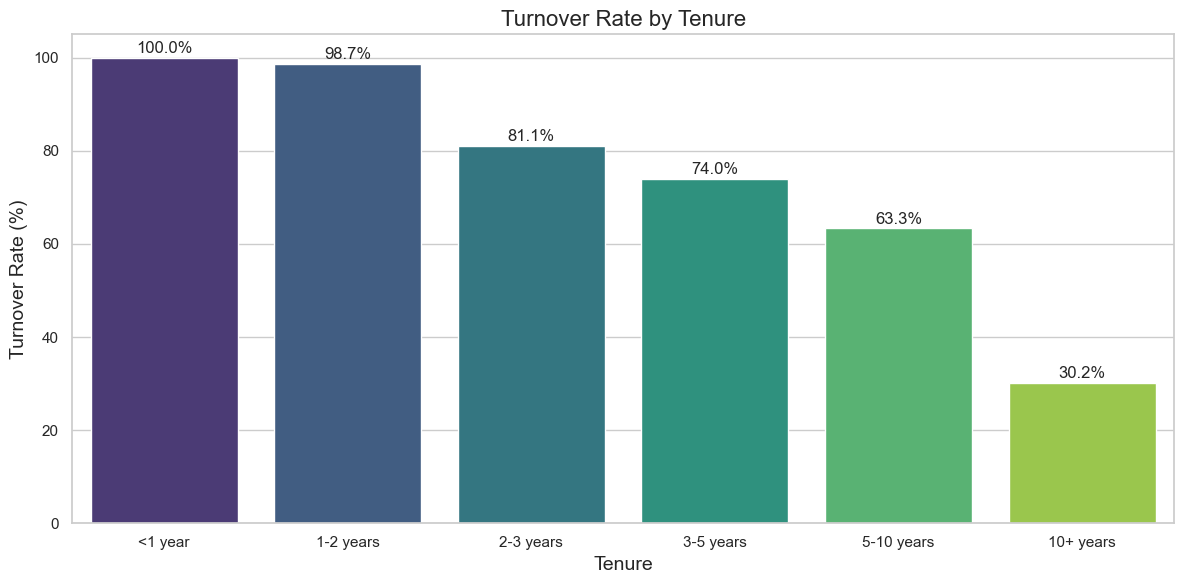

In [79]:
# Turnover by tenure
# Create tenure bins
tenure_bins = [0, 12, 24, 36, 60, 120, float('inf')]
tenure_labels = ['<1 year', '1-2 years', '2-3 years', '3-5 years', '5-10 years', '10+ years']
full_data['Tenure_Group'] = pd.cut(full_data['Tenure_in_Months'], bins=tenure_bins, labels=tenure_labels)

# Calculate turnover rate by tenure group
tenure_turnover = full_data.groupby('Tenure_Group', observed=True)['Turned_Over'].agg(['count', 'sum', 'mean'])
tenure_turnover.columns = ['Total', 'Left', 'Turnover_Rate']
tenure_turnover['Turnover_Rate'] = tenure_turnover['Turnover_Rate'] * 100

# Visualize turnover by tenure
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=tenure_turnover.index, hue=tenure_turnover.index, legend=False, y='Turnover_Rate', data=tenure_turnover, palette='viridis')
plt.title('Turnover Rate by Tenure', fontsize=16)
plt.xlabel('Tenure', fontsize=14)
plt.ylabel('Turnover Rate (%)', fontsize=14)

# Add value labels
for i, v in enumerate(tenure_turnover['Turnover_Rate']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=12)

plt.tight_layout()
plt.show()


## 3. Demographic Analysis

Let's analyze how turnover varies across different demographic groups, including gender, ethnicity, and age.


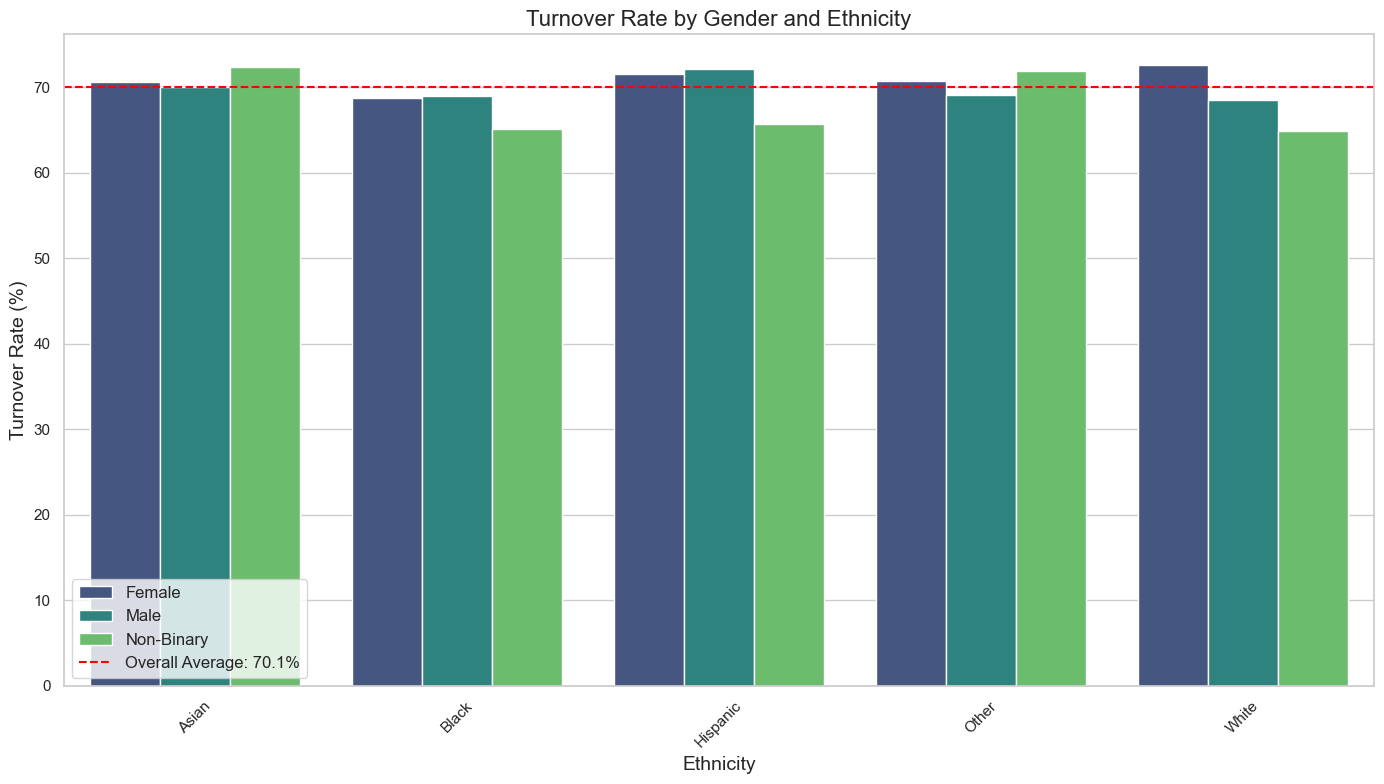

In [80]:
# Turnover by gender and ethnicity
demographic_turnover = full_data.groupby(['Gender', 'Ethnicity'], observed=True)['Turned_Over'].agg(['count', 'mean'])
demographic_turnover.columns = ['Total', 'Turnover_Rate']
demographic_turnover['Turnover_Rate'] = demographic_turnover['Turnover_Rate'] * 100
demographic_turnover = demographic_turnover.reset_index()

# Visualize turnover by gender and ethnicity
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Ethnicity', y='Turnover_Rate', hue='Gender', data=demographic_turnover, palette='viridis')
plt.title('Turnover Rate by Gender and Ethnicity', fontsize=16)
plt.xlabel('Ethnicity', fontsize=14)
plt.ylabel('Turnover Rate (%)', fontsize=14)
plt.legend(title='Gender', fontsize=12)
plt.xticks(rotation=45)

# Add a horizontal line for the overall turnover rate
plt.axhline(y=turnover_rate, color='red', linestyle='--', label=f'Overall Average: {turnover_rate:.1f}%')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


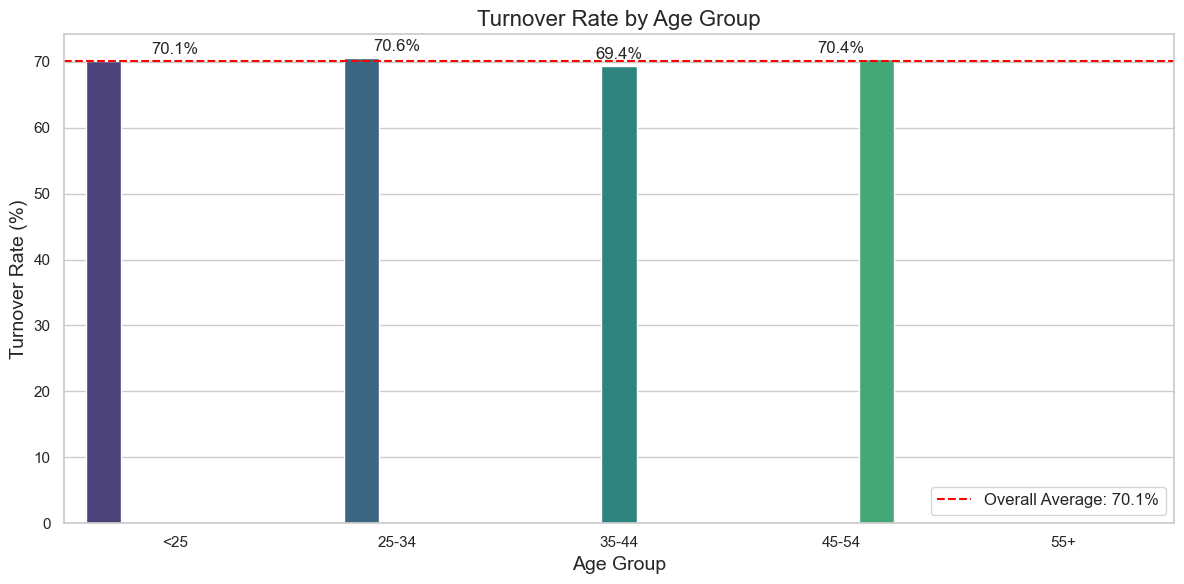

In [81]:
# Turnover by age group
age_turnover = full_data.groupby('Age_Group')['Turned_Over'].agg(['count', 'mean'])
age_turnover.columns = ['Total', 'Turnover_Rate']
age_turnover['Turnover_Rate'] = age_turnover['Turnover_Rate'] * 100
age_turnover = age_turnover.reset_index()

# Ensure age groups are in the correct order
age_order = ['<25', '25-34', '35-44', '45-54', '55+']
age_turnover['Age_Group'] = pd.Categorical(age_turnover['Age_Group'], categories=age_order, ordered=True)
age_turnover = age_turnover.sort_values('Age_Group')

# Visualize turnover by age group
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Age_Group', hue='Age_Group', y='Turnover_Rate', data=age_turnover, palette='viridis')
plt.title('Turnover Rate by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Turnover Rate (%)', fontsize=14)

# Add value labels
for i, v in enumerate(age_turnover['Turnover_Rate']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=12)

# Add a horizontal line for the overall turnover rate
plt.axhline(y=turnover_rate, color='red', linestyle='--', label=f'Overall Average: {turnover_rate:.1f}%')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


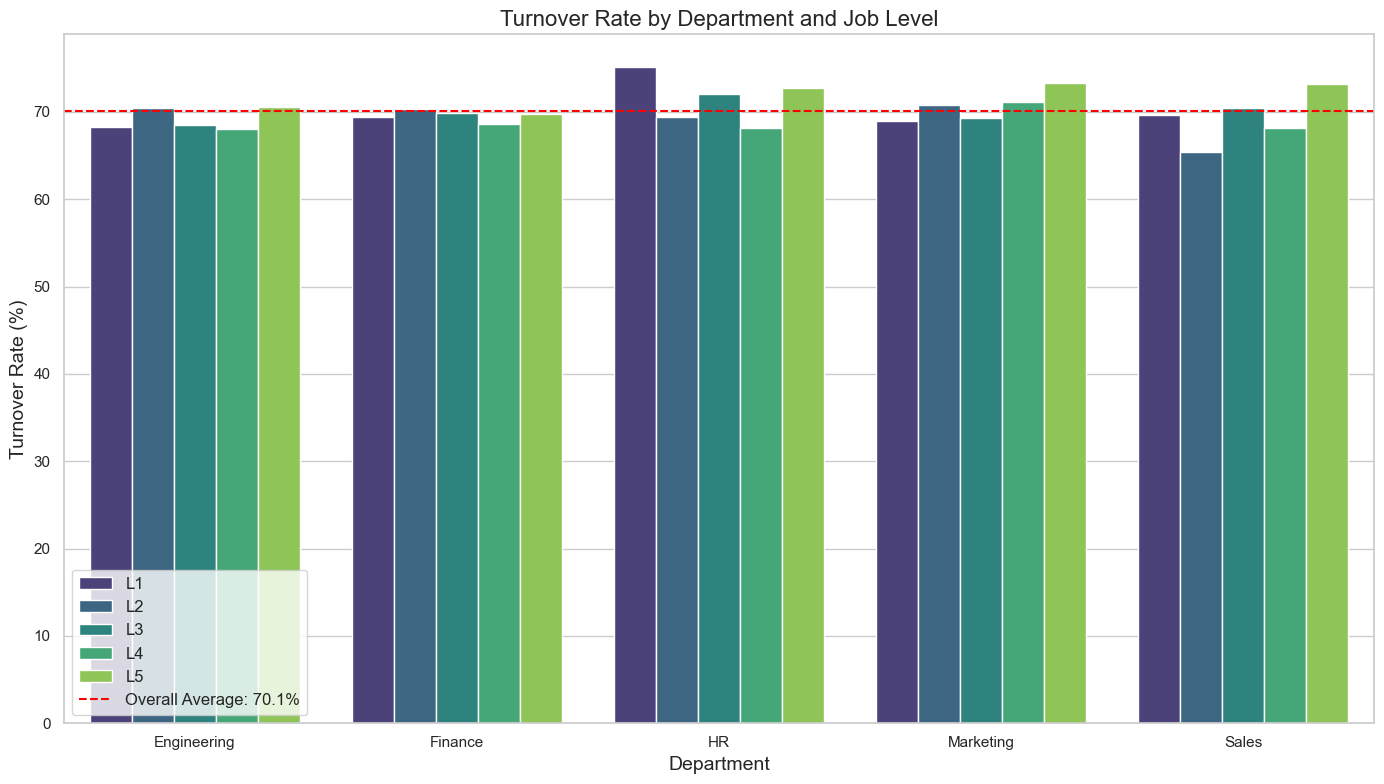

In [82]:
# Turnover by department and job level
dept_level_turnover = full_data.groupby(['Department', 'Job_Level'], observed=True)['Turned_Over'].agg(['count', 'mean'])
dept_level_turnover.columns = ['Total', 'Turnover_Rate']
dept_level_turnover['Turnover_Rate'] = dept_level_turnover['Turnover_Rate'] * 100
dept_level_turnover = dept_level_turnover.reset_index()

# Visualize turnover by department and job level
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Department', y='Turnover_Rate', hue='Job_Level', data=dept_level_turnover, palette='viridis')
plt.title('Turnover Rate by Department and Job Level', fontsize=16)
plt.xlabel('Department', fontsize=14)
plt.ylabel('Turnover Rate (%)', fontsize=14)
plt.legend(title='Job Level', fontsize=12)

# Add a horizontal line for the overall turnover rate
plt.axhline(y=turnover_rate, color='red', linestyle='--', label=f'Overall Average: {turnover_rate:.1f}%')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


## 4. Engagement and Satisfaction Analysis

Now let's examine how employee engagement and satisfaction metrics relate to turnover.


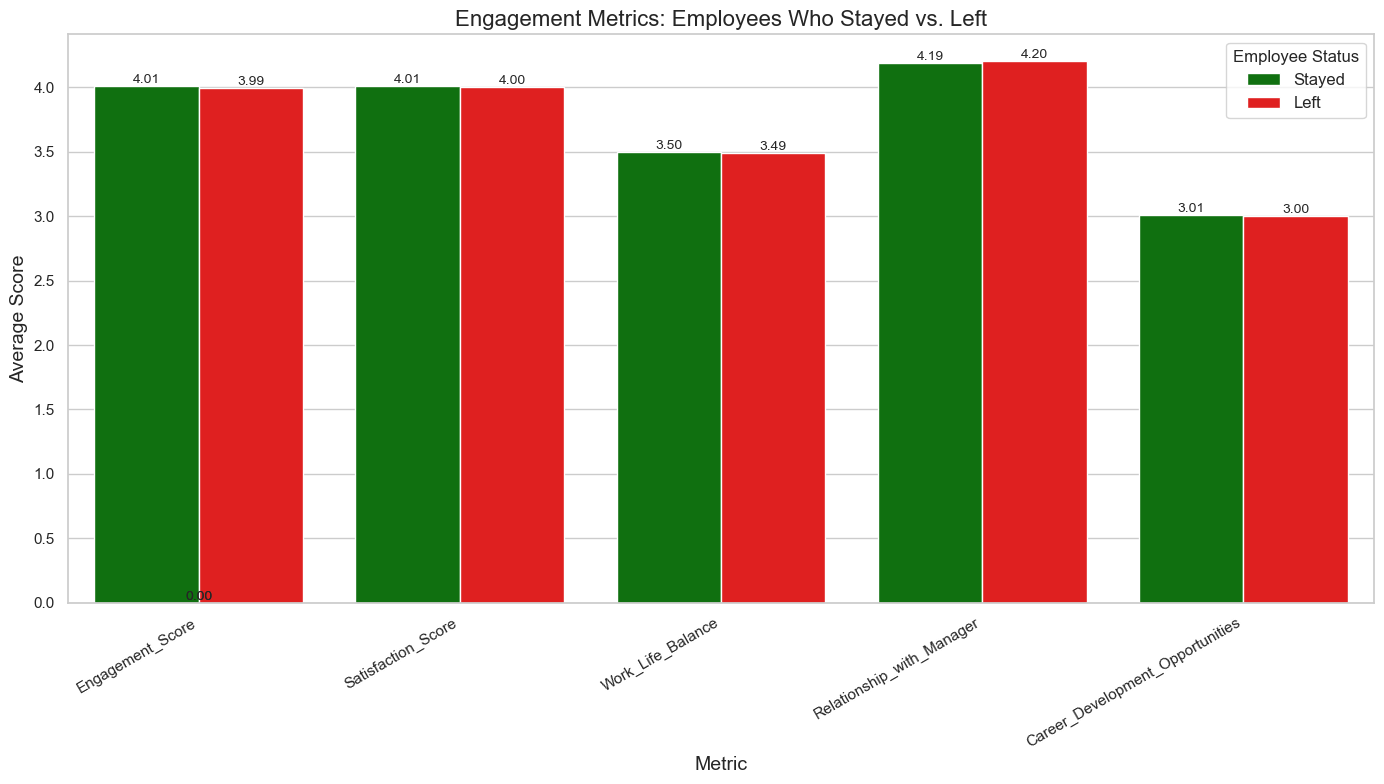

In [83]:
# Compare engagement metrics between employees who stayed vs. left
engagement_metrics = ['Engagement_Score', 'Satisfaction_Score', 'Work_Life_Balance', 
                      'Relationship_with_Manager', 'Career_Development_Opportunities']

# Calculate mean scores for each group
engagement_comparison = full_data.groupby('Turned_Over')[engagement_metrics].mean().reset_index()
engagement_comparison = pd.melt(engagement_comparison, id_vars=['Turned_Over'], 
                               value_vars=engagement_metrics, 
                               var_name='Metric', value_name='Score')
engagement_comparison['Turned_Over'] = engagement_comparison['Turned_Over'].map({0: 'Stayed', 1: 'Left'})

# Visualize engagement metrics comparison
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Metric', y='Score', hue='Turned_Over', data=engagement_comparison, palette=['green', 'red'])
plt.title('Engagement Metrics: Employees Who Stayed vs. Left', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.legend(title='Employee Status', fontsize=12)
plt.xticks(rotation=30, ha='right')

# Add value labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [84]:
# Statistical tests for engagement metrics
print("Statistical Tests for Engagement Metrics Between Employees Who Stayed vs. Left\n")
print("-" * 80)

for metric in engagement_metrics:
    stayed = full_data[full_data['Turned_Over'] == 0][metric]
    left = full_data[full_data['Turned_Over'] == 1][metric]

    # Perform t-test
    t_stat, p_val = scipy_stats.ttest_ind(stayed, left, equal_var=False)

    print(f"Metric: {metric}")
    print(f"Average for employees who stayed: {stayed.mean():.2f}")
    print(f"Average for employees who left: {left.mean():.2f}")
    print(f"Difference: {stayed.mean() - left.mean():.2f}")
    print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

    if p_val < 0.05:
        print("Result: Statistically significant difference")
    else:
        print("Result: No statistically significant difference")

    print("-" * 80)


Statistical Tests for Engagement Metrics Between Employees Who Stayed vs. Left

--------------------------------------------------------------------------------
Metric: Engagement_Score
Average for employees who stayed: 4.01
Average for employees who left: 3.99
Difference: 0.01
T-statistic: 1.20, p-value: 0.2293
Result: No statistically significant difference
--------------------------------------------------------------------------------
Metric: Satisfaction_Score
Average for employees who stayed: 4.01
Average for employees who left: 4.00
Difference: 0.01
T-statistic: 0.95, p-value: 0.3402
Result: No statistically significant difference
--------------------------------------------------------------------------------
Metric: Work_Life_Balance
Average for employees who stayed: 3.50
Average for employees who left: 3.49
Difference: 0.01
T-statistic: 0.76, p-value: 0.4480
Result: No statistically significant difference
-----------------------------------------------------------------------

C:\Users\PC\AppData\Local\Temp\ipykernel_18624\2147477353.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Career_Development_Opportunities_Category', y='Turnover_Rate',


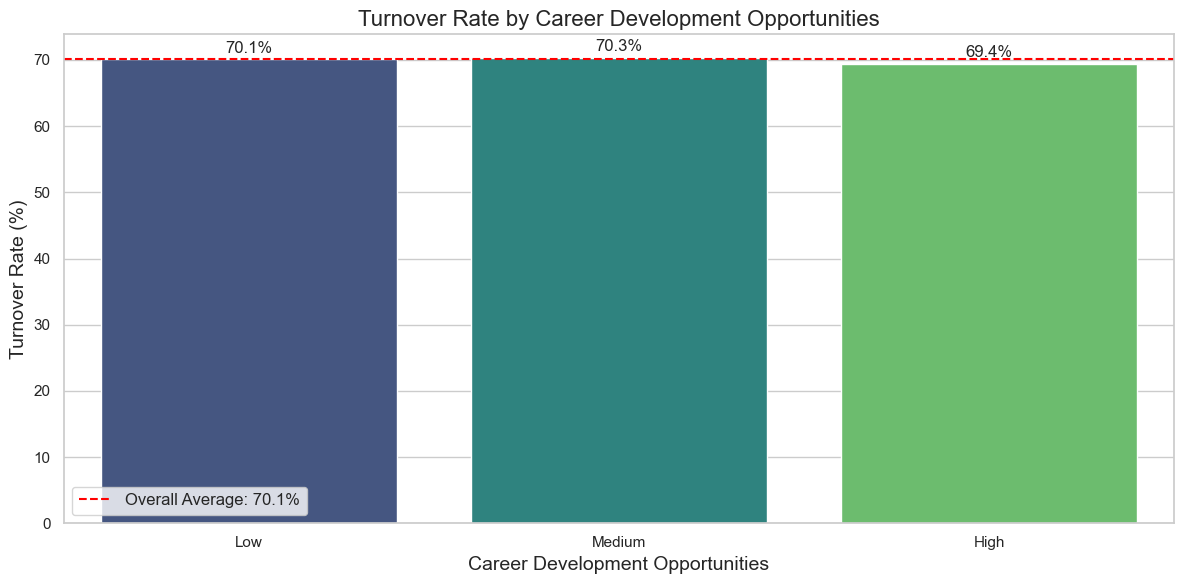

In [85]:
# Create engagement score categories
def categorize_score(score, metric):
    if metric == 'Career_Development_Opportunities':
        if score < 2.5:
            return 'Low'
        elif score < 3.5:
            return 'Medium'
        else:
            return 'High'
    else:
        if score < 3.5:
            return 'Low'
        elif score < 4.5:
            return 'Medium'
        else:
            return 'High'

# Apply categorization to each metric
for metric in engagement_metrics:
    full_data[f'{metric}_Category'] = full_data[metric].apply(lambda x: categorize_score(x, metric))

# Calculate turnover rate by Career Development Opportunities category
career_dev_turnover = full_data.groupby('Career_Development_Opportunities_Category')['Turned_Over'].agg(['count', 'mean'])
career_dev_turnover.columns = ['Total', 'Turnover_Rate']
career_dev_turnover['Turnover_Rate'] = career_dev_turnover['Turnover_Rate'] * 100
career_dev_turnover = career_dev_turnover.reset_index()

# Ensure categories are in the correct order
category_order = ['Low', 'Medium', 'High']
career_dev_turnover['Career_Development_Opportunities_Category'] = pd.Categorical(
    career_dev_turnover['Career_Development_Opportunities_Category'], 
    categories=category_order, 
    ordered=True
)
career_dev_turnover = career_dev_turnover.sort_values('Career_Development_Opportunities_Category')

# Visualize turnover by career development opportunities
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Career_Development_Opportunities_Category', y='Turnover_Rate', 
                data=career_dev_turnover, palette='viridis')
plt.title('Turnover Rate by Career Development Opportunities', fontsize=16)
plt.xlabel('Career Development Opportunities', fontsize=14)
plt.ylabel('Turnover Rate (%)', fontsize=14)

# Add value labels
for i, v in enumerate(career_dev_turnover['Turnover_Rate']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=12)

# Add a horizontal line for the overall turnover rate
plt.axhline(y=turnover_rate, color='red', linestyle='--', label=f'Overall Average: {turnover_rate:.1f}%')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


## 5. Compensation Analysis

Let's analyze how compensation relates to employee turnover.


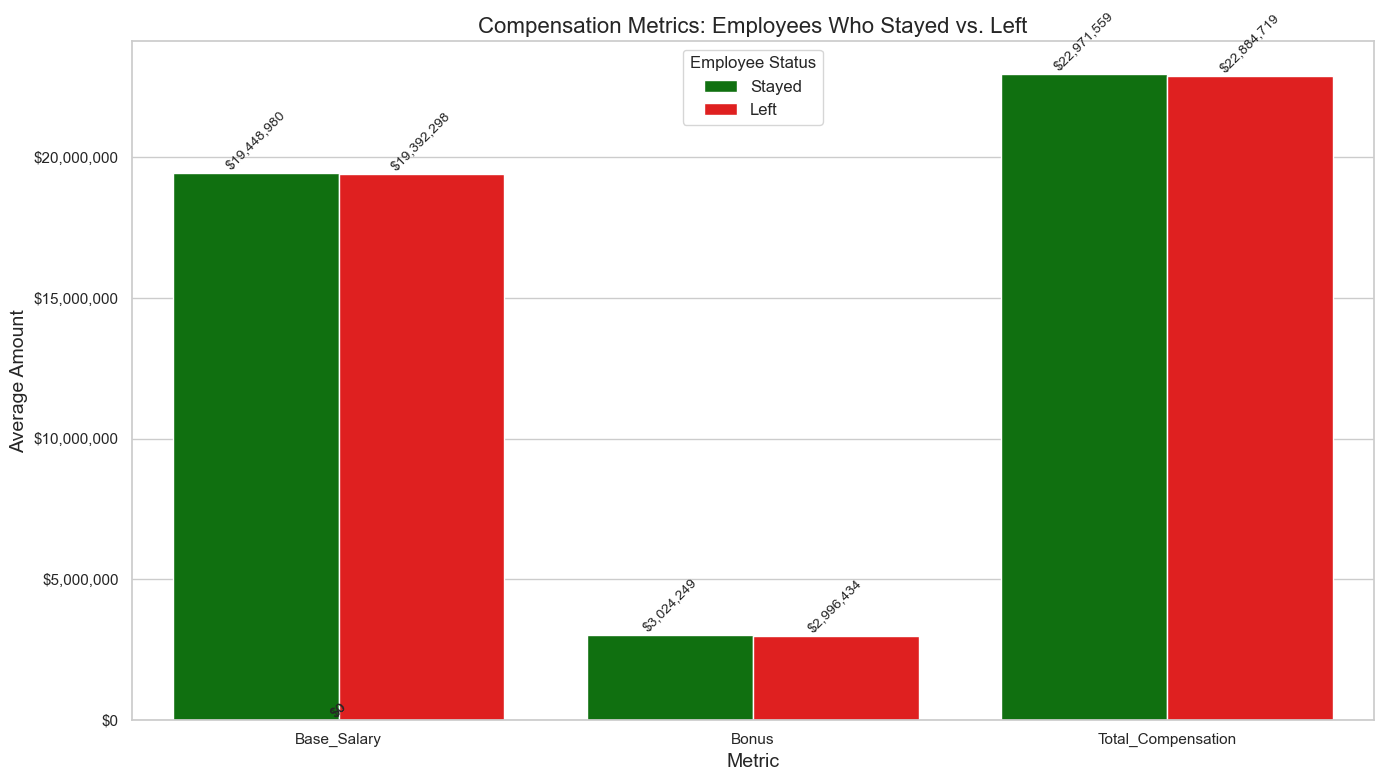

In [86]:
# Compare compensation between employees who stayed vs. left
compensation_metrics = ['Base_Salary', 'Bonus', 'Total_Compensation']

# Calculate mean compensation for each group
compensation_comparison = full_data.groupby('Turned_Over')[compensation_metrics].mean().reset_index()
compensation_comparison = pd.melt(compensation_comparison, id_vars=['Turned_Over'], 
                                 value_vars=compensation_metrics, 
                                 var_name='Metric', value_name='Amount')
compensation_comparison['Turned_Over'] = compensation_comparison['Turned_Over'].map({0: 'Stayed', 1: 'Left'})

# Visualize compensation comparison
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Metric', y='Amount', hue='Turned_Over', data=compensation_comparison, palette=['green', 'red'])
plt.title('Compensation Metrics: Employees Who Stayed vs. Left', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Average Amount', fontsize=14)
plt.legend(title='Employee Status', fontsize=12)

# Format y-axis labels to show currency
import matplotlib.ticker as mtick
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

# Add value labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'${p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=10, rotation=45)

plt.tight_layout()
plt.show()


In [87]:
# Statistical tests for compensation fairness
print("Statistical Tests for Compensation Fairness\n")
print("-" * 80)

# Test for gender-based compensation differences within each salary grade
for grade in full_data['Salary_Grade'].unique():
    print(f"Salary Grade {grade}:")
    grade_data = full_data[full_data['Salary_Grade'] == grade]

    # Extract salary data by gender
    male_salary = grade_data.loc[grade_data['Gender'] == 'Male', 'Base_Salary'].values
    female_salary = grade_data.loc[grade_data['Gender'] == 'Female', 'Base_Salary'].values
    non_binary_salary = grade_data.loc[grade_data['Gender'] == 'Non-Binary', 'Base_Salary'].values

    # Perform ANOVA test
    result = scipy_stats.f_oneway(male_salary, female_salary, non_binary_salary)

    print(f"  Male average salary: ${np.mean(male_salary):,.2f} (n={len(male_salary)})")
    print(f"  Female average salary: ${np.mean(female_salary):,.2f} (n={len(female_salary)})")
    print(f"  Non-Binary average salary: ${np.mean(non_binary_salary):,.2f} (n={len(non_binary_salary)})")
    print(f"  ANOVA F-statistic: {result.statistic:.2f}, p-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("  Result: Statistically significant differences detected")
    else:
        print("  Result: No statistically significant differences detected")

    print("-" * 80)


Statistical Tests for Compensation Fairness

--------------------------------------------------------------------------------
Salary Grade E:
  Male average salary: $29,792,011.17 (n=951)
  Female average salary: $29,985,094.58 (n=879)
  Non-Binary average salary: $29,474,763.13 (n=198)
  ANOVA F-statistic: 0.67, p-value: 0.5115
  Result: No statistically significant differences detected
--------------------------------------------------------------------------------
Salary Grade C:
  Male average salary: $18,038,823.21 (n=874)
  Female average salary: $18,119,238.03 (n=916)
  Non-Binary average salary: $17,735,888.47 (n=214)
  ANOVA F-statistic: 0.81, p-value: 0.4460
  Result: No statistically significant differences detected
--------------------------------------------------------------------------------
Salary Grade D:
  Male average salary: $22,002,703.32 (n=922)
  Female average salary: $22,155,647.21 (n=889)
  Non-Binary average salary: $22,234,663.14 (n=178)
  ANOVA F-statistic:

<Figure size 1600x800 with 0 Axes>

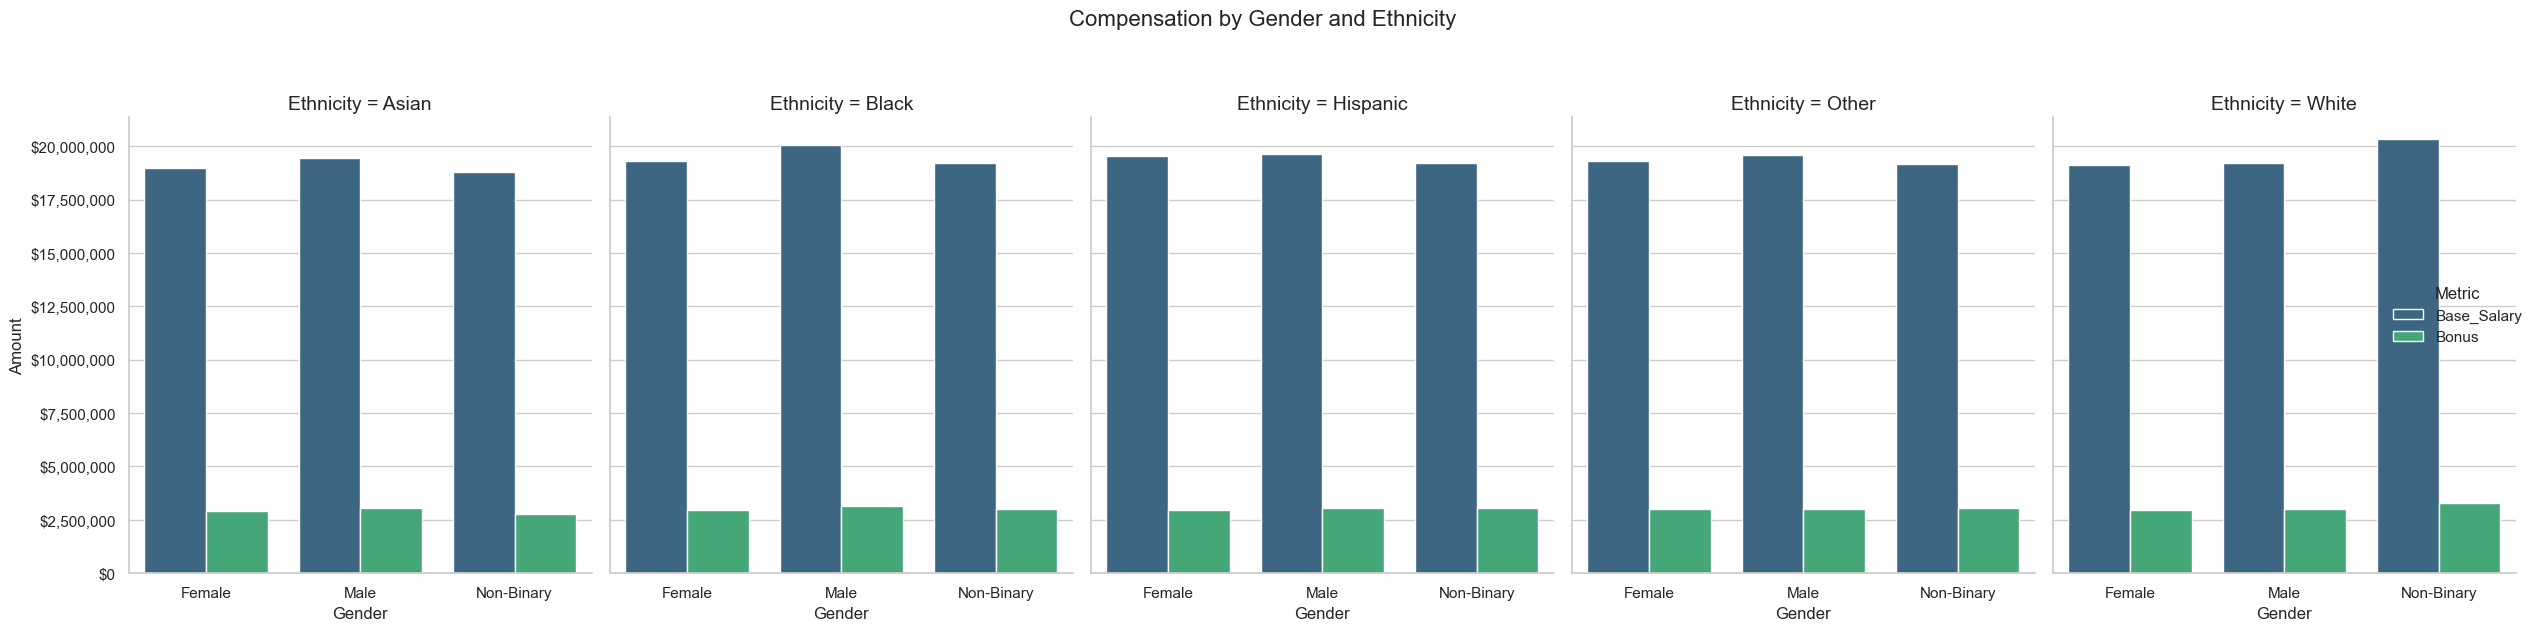

In [88]:
# Analyze compensation by ethnicity
comp_analysis = full_data.groupby(['Gender', 'Ethnicity'], observed=True).agg({'Base_Salary': 'mean', 'Bonus': 'mean'})
comp_analysis = comp_analysis.stack().reset_index()
comp_analysis.columns = ['Gender', 'Ethnicity', 'Metric', 'Value']

# Visualize compensation by gender and ethnicity
plt.figure(figsize=(16, 8))
ax = sns.catplot(
    data=comp_analysis,
    x="Gender",
    y="Value",
    hue="Metric",
    col="Ethnicity",
    kind="bar",
    height=6,
    aspect=0.8,
    palette="viridis"
)

# Format y-axis labels to show currency
for ax in ax.axes.flat:
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
    ax.set_title(ax.get_title(), fontsize=14)
    ax.set_xlabel('Gender', fontsize=12)
    ax.set_ylabel('Amount', fontsize=12)

plt.suptitle('Compensation by Gender and Ethnicity', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


## 6. Performance Analysis

Let's examine how performance metrics relate to turnover.


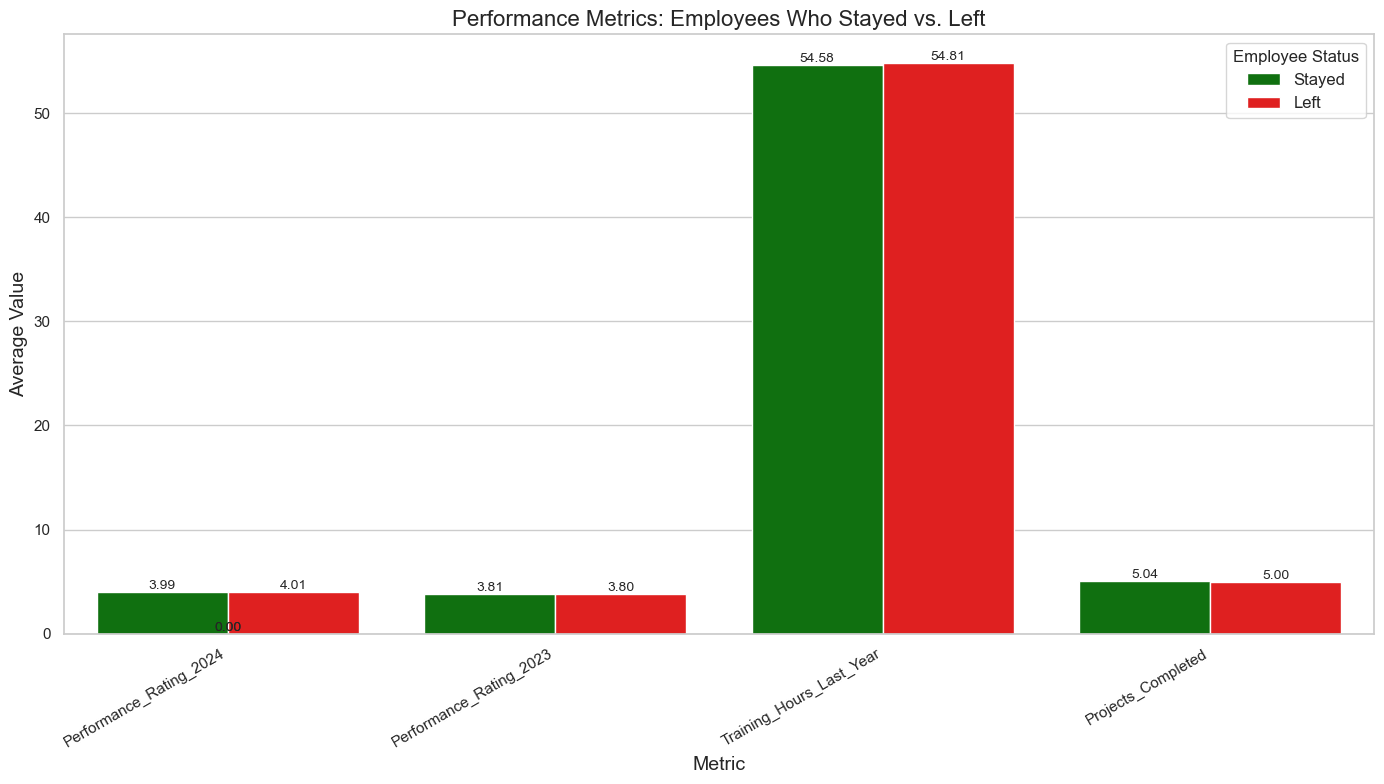

In [89]:
# Compare performance metrics between employees who stayed vs. left
performance_metrics = ['Performance_Rating_2024', 'Performance_Rating_2023', 
                       'Training_Hours_Last_Year', 'Projects_Completed']

# Calculate mean performance for each group
performance_comparison = full_data.groupby('Turned_Over')[performance_metrics].mean().reset_index()
performance_comparison = pd.melt(performance_comparison, id_vars=['Turned_Over'], 
                               value_vars=performance_metrics, 
                               var_name='Metric', value_name='Value')
performance_comparison['Turned_Over'] = performance_comparison['Turned_Over'].map({0: 'Stayed', 1: 'Left'})

# Visualize performance comparison
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Metric', y='Value', hue='Turned_Over', data=performance_comparison, palette=['green', 'red'])
plt.title('Performance Metrics: Employees Who Stayed vs. Left', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.legend(title='Employee Status', fontsize=12)
plt.xticks(rotation=30, ha='right')

# Add value labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_18624\3851062999.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Turned_Over', y='Rating_Change', data=rating_change_by_turnover, palette=['green', 'red'])


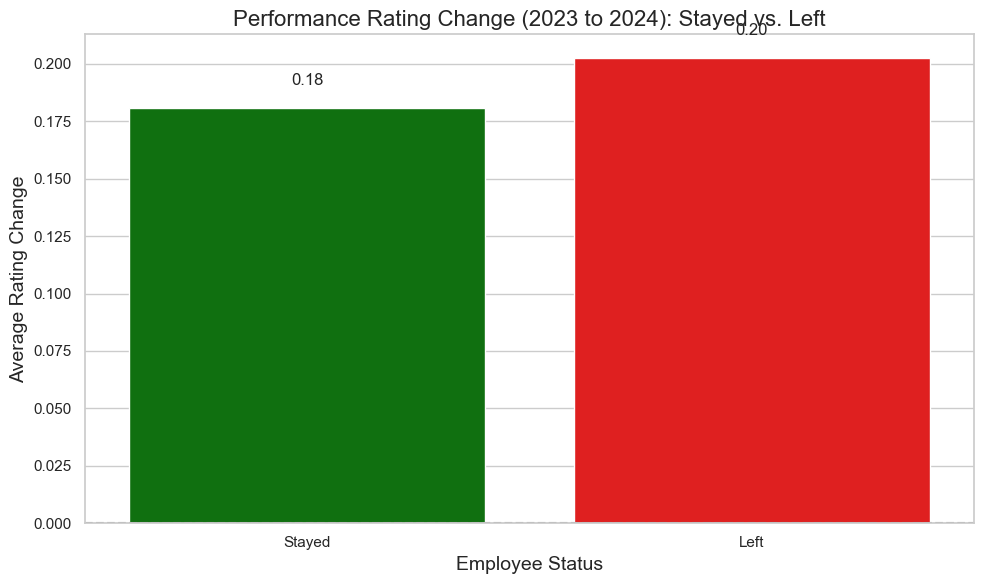

In [90]:
# Performance rating changes between 2023 and 2024
full_data['Rating_Change'] = full_data['Performance_Rating_2024'] - full_data['Performance_Rating_2023']

# Compare rating changes between employees who stayed vs. left
rating_change_by_turnover = full_data.groupby('Turned_Over')['Rating_Change'].mean().reset_index()
rating_change_by_turnover['Turned_Over'] = rating_change_by_turnover['Turned_Over'].map({0: 'Stayed', 1: 'Left'})

# Visualize rating changes
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Turned_Over', y='Rating_Change', data=rating_change_by_turnover, palette=['green', 'red'])
plt.title('Performance Rating Change (2023 to 2024): Stayed vs. Left', fontsize=16)
plt.xlabel('Employee Status', fontsize=14)
plt.ylabel('Average Rating Change', fontsize=14)

# Add value labels
for i, v in enumerate(rating_change_by_turnover['Rating_Change']):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=12)

# Add a horizontal line at zero
plt.axhline(y=0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()


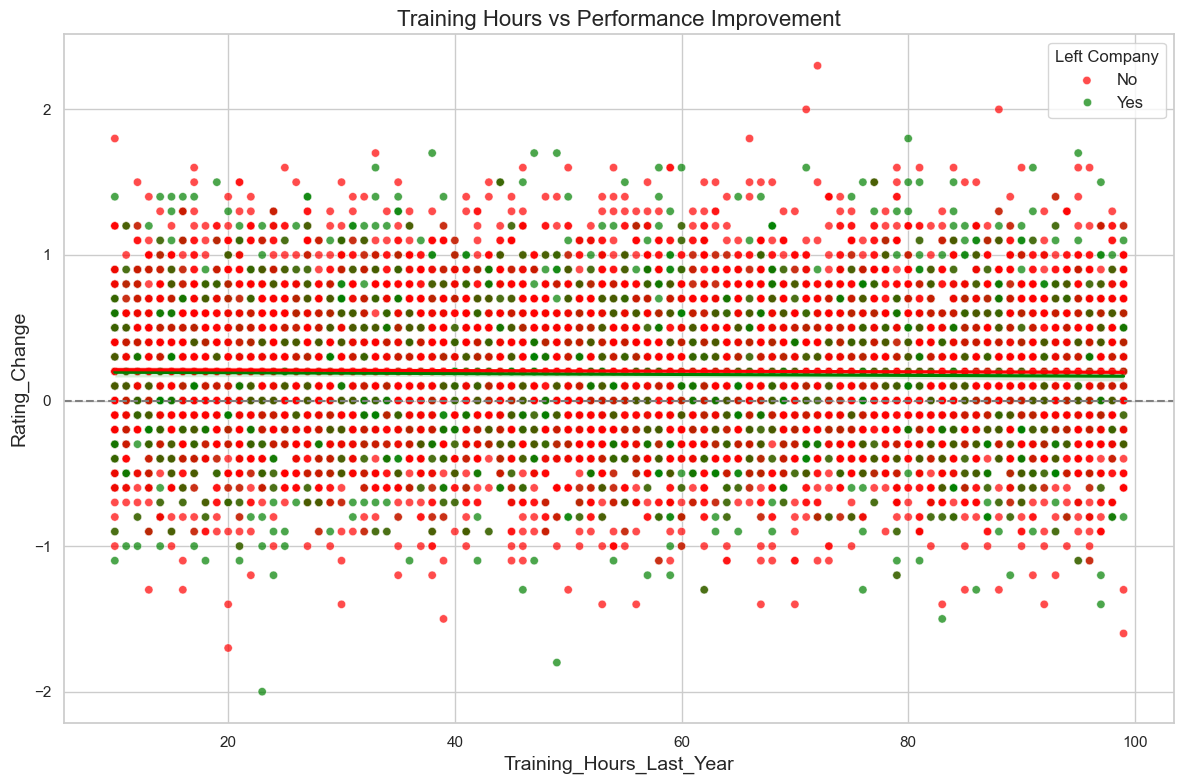

In [91]:
# Relationship between training hours and performance improvement
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x='Training_Hours_Last_Year', y='Rating_Change', 
                    hue='Turned_Over', data=full_data, 
                    palette={0: 'green', 1: 'red'}, alpha=0.7)
plt.title('Training Hours vs Performance Improvement', fontsize=16)
plt.xlabel('Training Hours Last Year', fontsize=14)
plt.ylabel('Performance Rating Change', fontsize=14)
plt.legend(title='Left Company', labels=['No', 'Yes'], fontsize=12)

# Add a horizontal line at zero
plt.axhline(y=0, color='gray', linestyle='--')

# Add regression lines for each group
for turned_over, color in zip([0, 1], ['green', 'red']):
    subset = full_data[full_data['Turned_Over'] == turned_over]
    if len(subset) > 1:  # Ensure we have enough data points
        sns.regplot(x='Training_Hours_Last_Year', y='Rating_Change', 
                   data=subset, scatter=False, color=color, ax=ax)

plt.tight_layout()
plt.show()


## 7. Exit Survey Analysis

Let's analyze the exit survey data to understand why employees leave.


C:\Users\PC\AppData\Local\Temp\ipykernel_18624\1299744962.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=primary_reasons, palette='viridis')


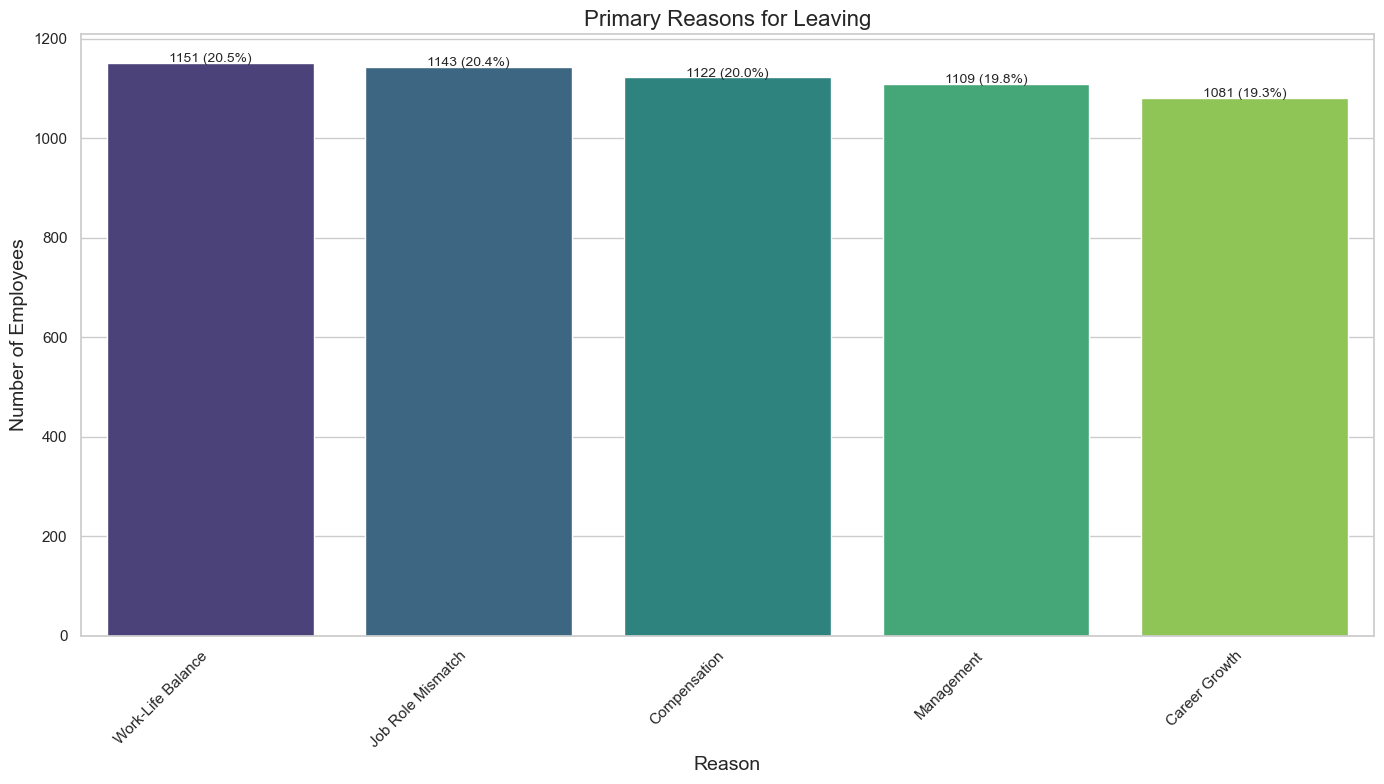

In [92]:
# Filter to only employees who have left the company
exited_employees = full_data[full_data['Exit_Date'].notnull()]

# Count of primary reasons for leaving
primary_reasons = exited_employees['Primary_Reason_for_Leaving'].value_counts().reset_index()
primary_reasons.columns = ['Reason', 'Count']
primary_reasons['Percentage'] = primary_reasons['Count'] / primary_reasons['Count'].sum() * 100

# Sort by count
primary_reasons = primary_reasons.sort_values('Count', ascending=False)

# Visualize primary reasons
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Reason', y='Count', data=primary_reasons, palette='viridis')
plt.title('Primary Reasons for Leaving', fontsize=16)
plt.xlabel('Reason', fontsize=14)
plt.ylabel('Number of Employees', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels with percentages
for i, v in enumerate(zip(primary_reasons['Count'], primary_reasons['Percentage'])):
    ax.text(i, v[0] + 1, f'{v[0]} ({v[1]:.1f}%)', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_18624\177431599.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=secondary_reasons, palette='viridis')


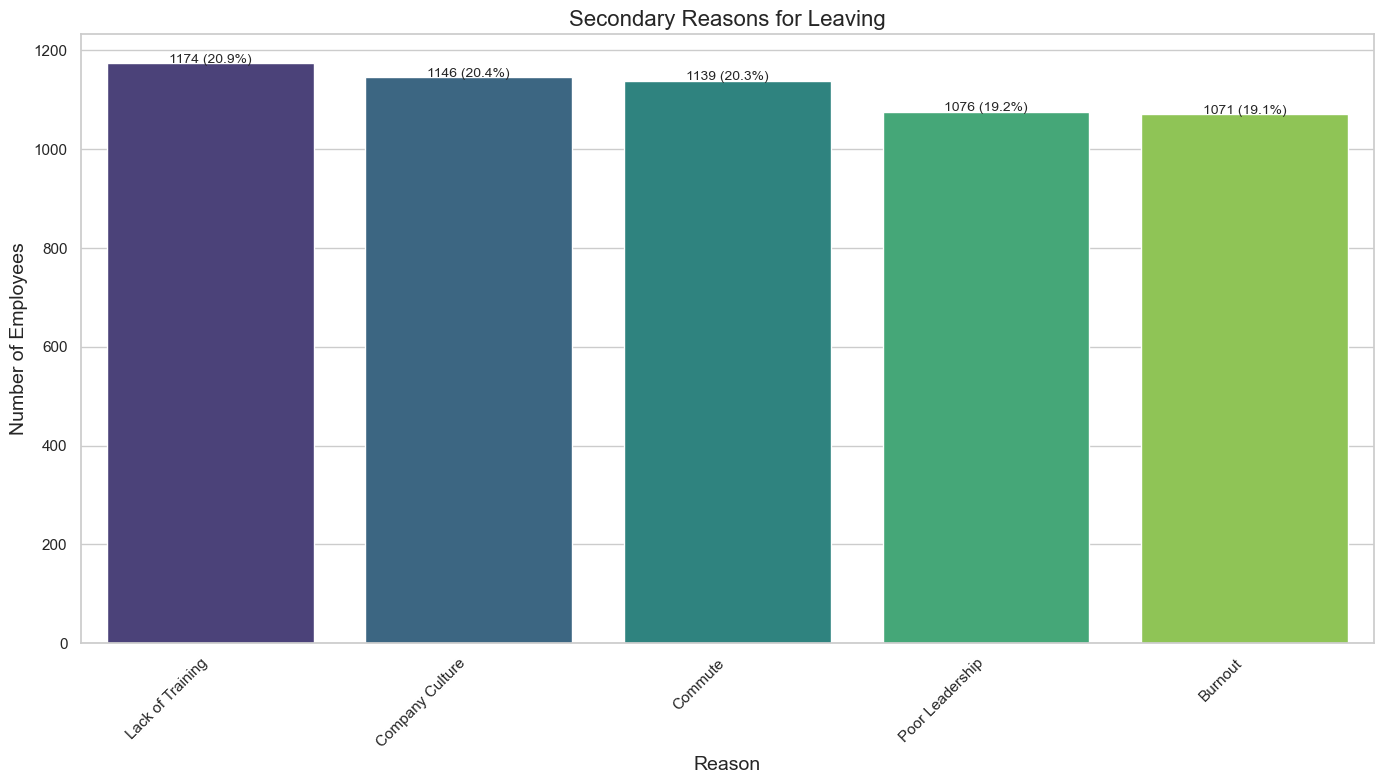

In [93]:
# Count of secondary reasons for leaving
secondary_reasons = exited_employees['Secondary_Reason'].value_counts().reset_index()
secondary_reasons.columns = ['Reason', 'Count']
secondary_reasons['Percentage'] = secondary_reasons['Count'] / secondary_reasons['Count'].sum() * 100

# Sort by count
secondary_reasons = secondary_reasons.sort_values('Count', ascending=False)

# Visualize secondary reasons
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Reason', y='Count', data=secondary_reasons, palette='viridis')
plt.title('Secondary Reasons for Leaving', fontsize=16)
plt.xlabel('Reason', fontsize=14)
plt.ylabel('Number of Employees', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels with percentages
for i, v in enumerate(zip(secondary_reasons['Count'], secondary_reasons['Percentage'])):
    ax.text(i, v[0] + 1, f'{v[0]} ({v[1]:.1f}%)', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


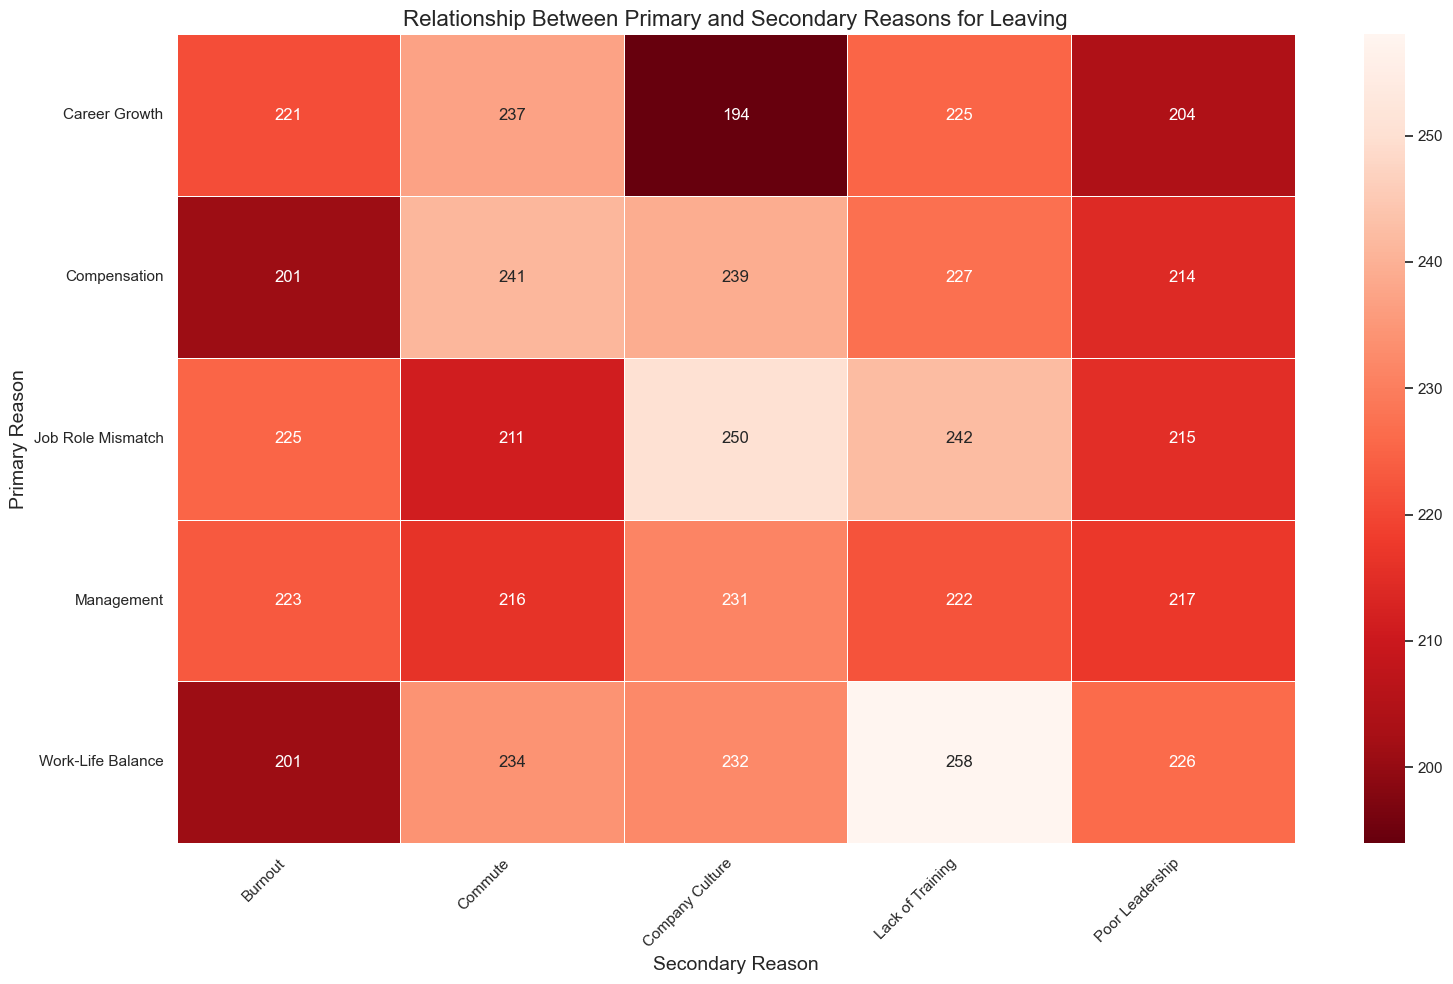

In [103]:
# Create a heatmap of primary and secondary reasons
reason_matrix = pd.crosstab(exited_employees['Primary_Reason_for_Leaving'], 
                           exited_employees['Secondary_Reason'])

plt.figure(figsize=(16, 10))
sns.heatmap(reason_matrix, annot=True, fmt='d', cmap='Reds_r', linewidths=.5)
plt.title('Relationship Between Primary and Secondary Reasons for Leaving', fontsize=16)
plt.xlabel('Secondary Reason', fontsize=14)
plt.ylabel('Primary Reason', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_18624\4136146865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Aspect', y='Count', data=liked_most, palette='viridis')


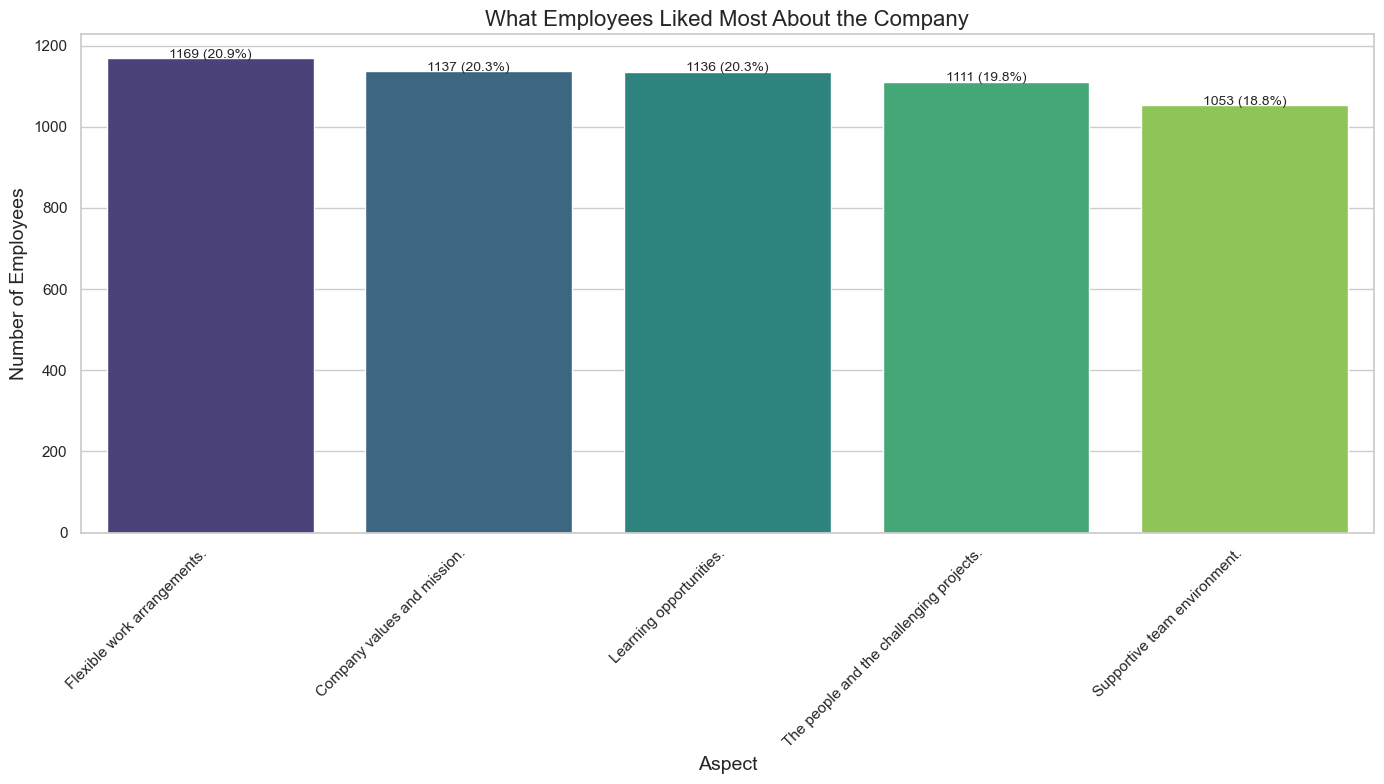

In [95]:
# What employees liked most about the company
liked_most = exited_employees['Like_Most_About_Company'].value_counts().reset_index()
liked_most.columns = ['Aspect', 'Count']
liked_most['Percentage'] = liked_most['Count'] / liked_most['Count'].sum() * 100

# Sort by count
liked_most = liked_most.sort_values('Count', ascending=False)

# Visualize what employees liked most
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Aspect', y='Count', data=liked_most, palette='viridis')
plt.title('What Employees Liked Most About the Company', fontsize=16)
plt.xlabel('Aspect', fontsize=14)
plt.ylabel('Number of Employees', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels with percentages
for i, v in enumerate(zip(liked_most['Count'], liked_most['Percentage'])):
    ax.text(i, v[0] + 1, f'{v[0]} ({v[1]:.1f}%)', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_18624\258990030.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Area', y='Count', data=improvement_areas, palette='viridis')


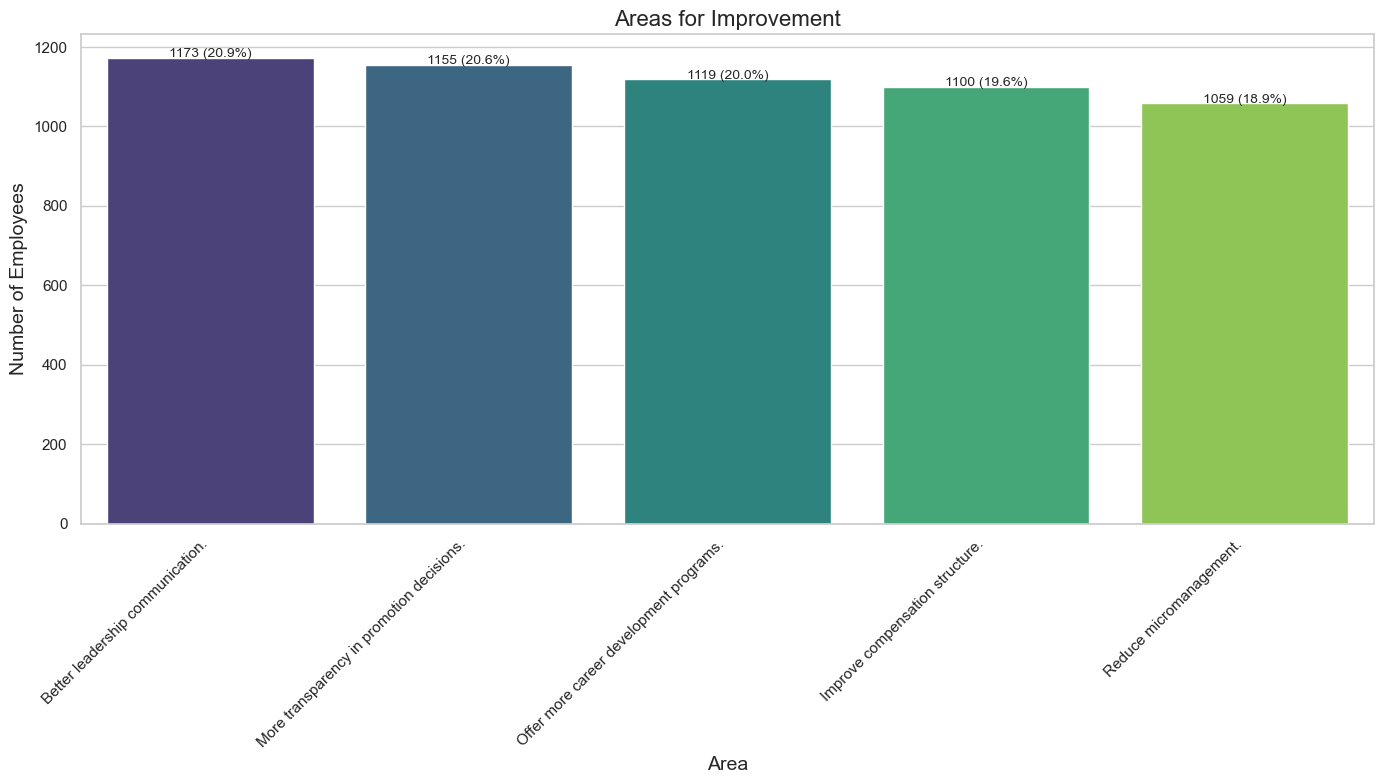

In [96]:
# Areas for improvement
improvement_areas = exited_employees['Improvement_Areas'].value_counts().reset_index()
improvement_areas.columns = ['Area', 'Count']
improvement_areas['Percentage'] = improvement_areas['Count'] / improvement_areas['Count'].sum() * 100

# Sort by count
improvement_areas = improvement_areas.sort_values('Count', ascending=False)

# Visualize improvement areas
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Area', y='Count', data=improvement_areas, palette='viridis')
plt.title('Areas for Improvement', fontsize=16)
plt.xlabel('Area', fontsize=14)
plt.ylabel('Number of Employees', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels with percentages
for i, v in enumerate(zip(improvement_areas['Count'], improvement_areas['Percentage'])):
    ax.text(i, v[0] + 1, f'{v[0]} ({v[1]:.1f}%)', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## 8. Predictive Modeling

Let's build a simple model to predict employee turnover risk based on the factors we've analyzed.


Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.94      0.77      1952
           1       0.46      0.10      0.17      1048

    accuracy                           0.64      3000
   macro avg       0.56      0.52      0.47      3000
weighted avg       0.59      0.64      0.56      3000


Confusion Matrix:


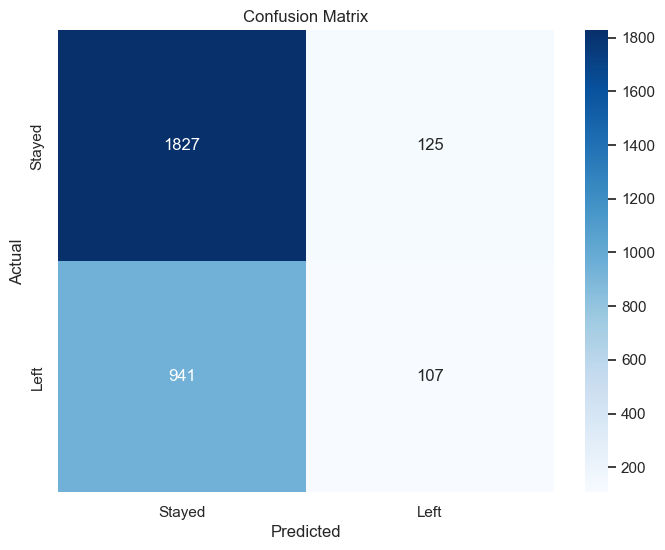


ROC AUC Score: 0.6144


In [97]:
# Prepare data for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Select features for the model
features = [
    'Age', 'Tenure_in_Months', 'Time_in_Current_Role',
    'Engagement_Score', 'Satisfaction_Score', 'Work_Life_Balance',
    'Relationship_with_Manager', 'Career_Development_Opportunities',
    'Performance_Rating_2024', 'Performance_Rating_2023',
    'Training_Hours_Last_Year', 'Projects_Completed',
    'Gender', 'Ethnicity', 'Department', 'Job_Level', 'Employment_Type'
]

# Create X (features) and y (target)
X = full_data[features].copy()
y = full_data['Voluntary_Turnover']  # Predicting voluntary turnover

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify categorical columns
categorical_cols = ['Gender', 'Ethnicity', 'Department', 'Job_Level', 'Employment_Type']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Create and train the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stayed', 'Left'], 
            yticklabels=['Stayed', 'Left'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


C:\Users\PC\AppData\Local\Temp\ipykernel_18624\4021193519.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


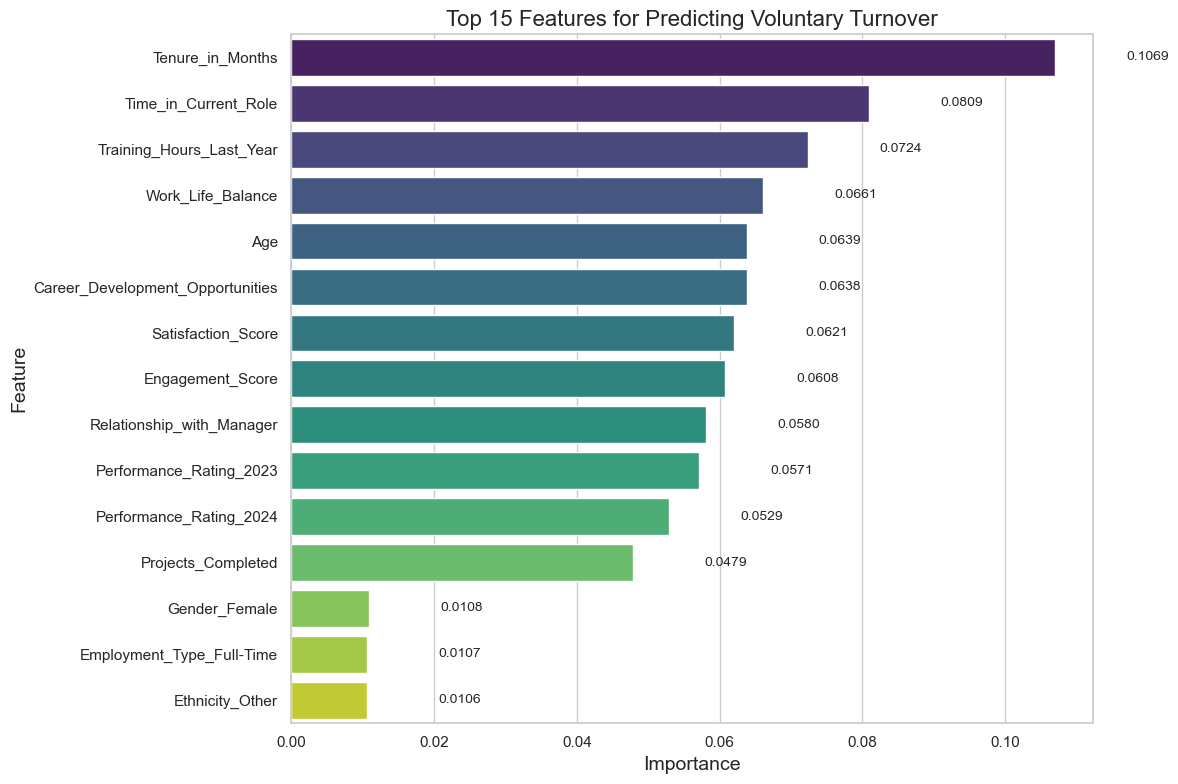

In [98]:
# Feature importance
import pandas as pd
import numpy as np

# Get feature names after one-hot encoding
ohe = model.named_steps['preprocessor'].transformers_[1][1]
cat_features = ohe.get_feature_names_out(categorical_cols).tolist()
feature_names = numerical_cols + cat_features

# Get feature importances
importances = model.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)

# Visualize feature importance
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Top 15 Features for Predicting Voluntary Turnover', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Add value labels
for i, v in enumerate(feature_importance['Importance']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


## 9. Fairness Analysis

Let's evaluate the fairness of our predictive model across different demographic groups to ensure our turnover predictions and interventions don't disproportionately impact protected groups.


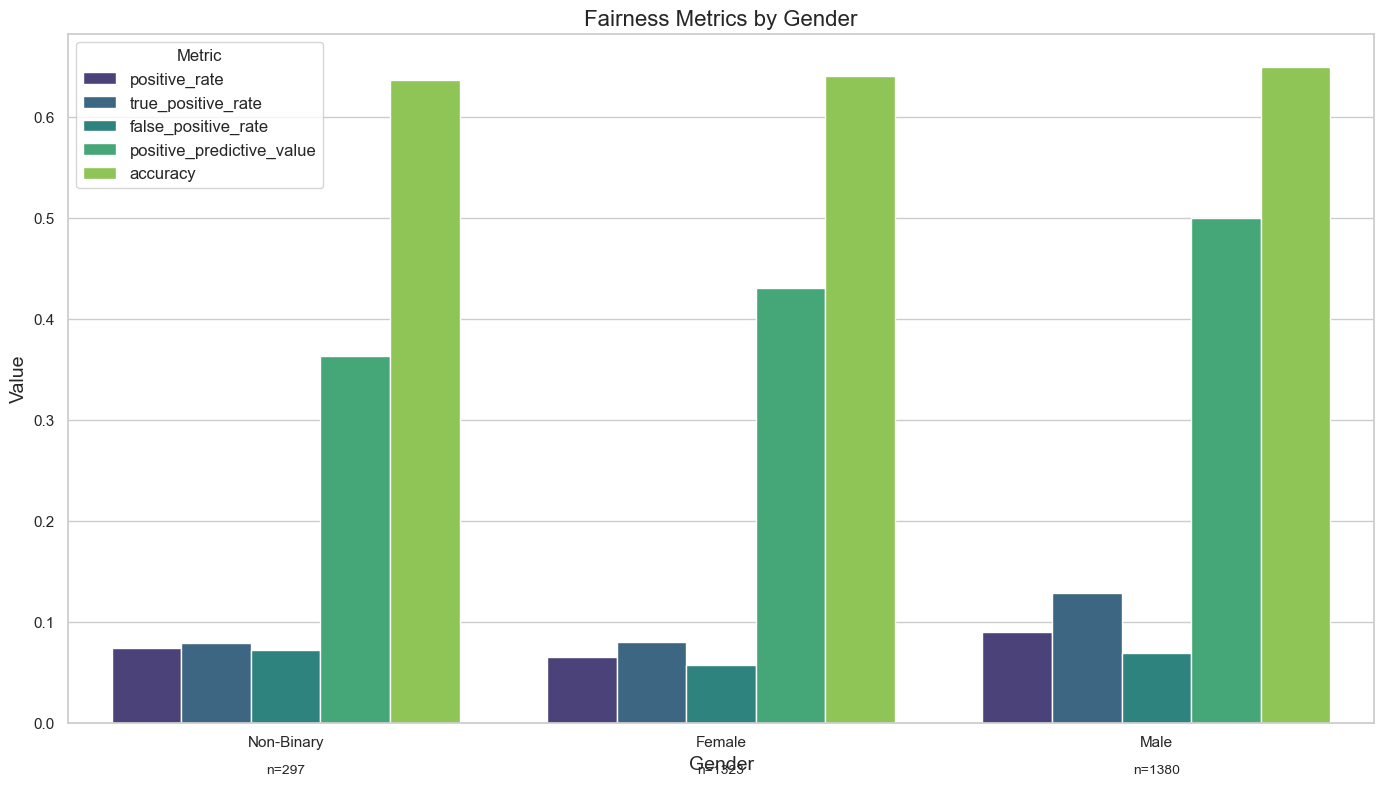

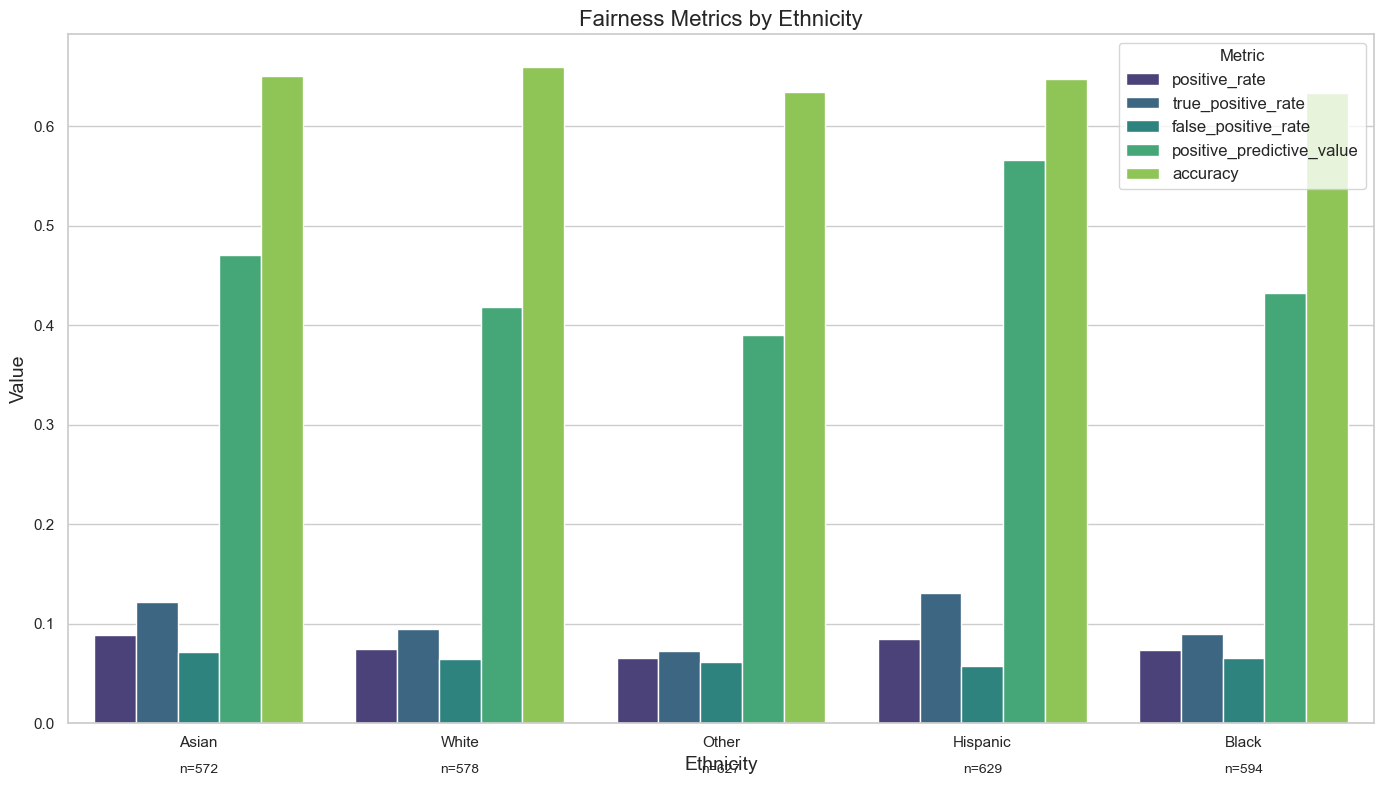

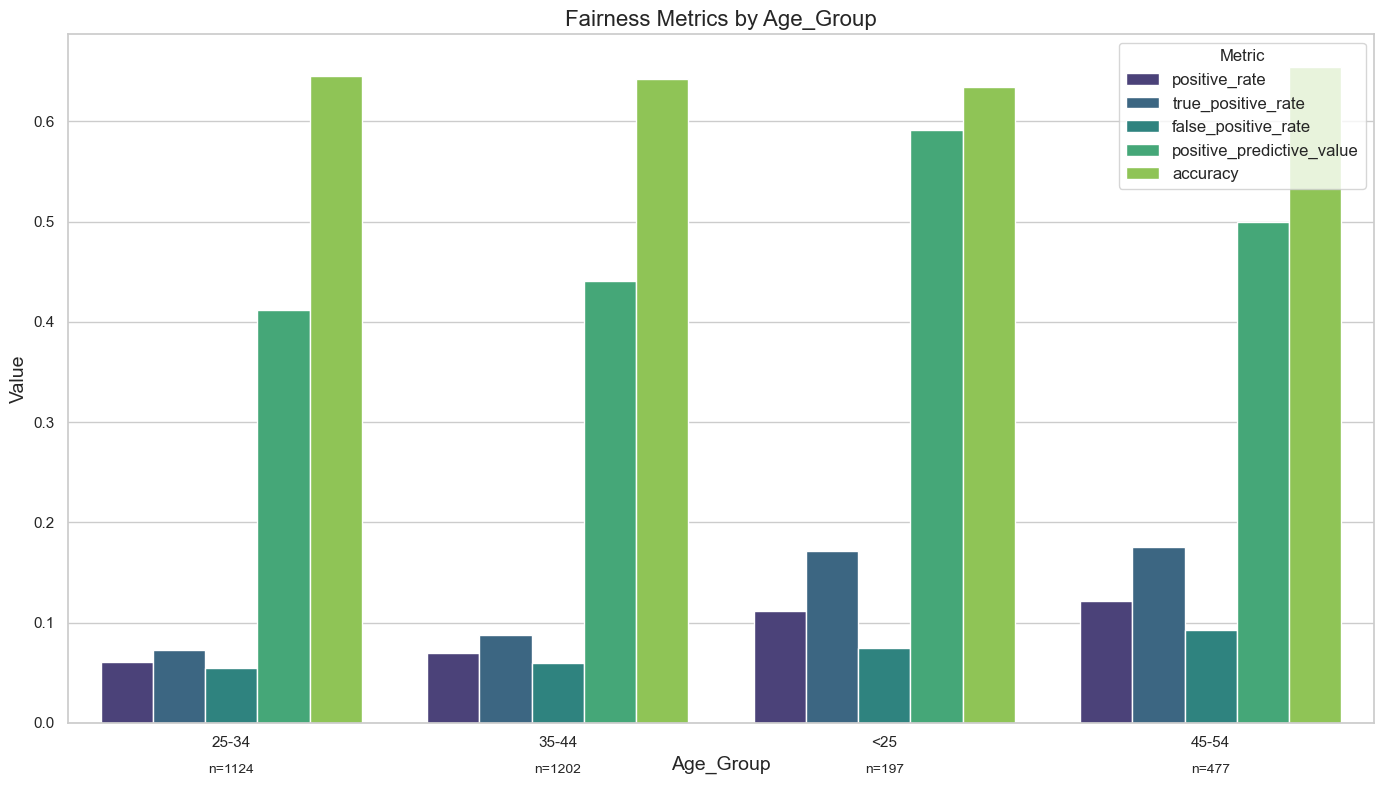

In [99]:
# Import fairness metrics libraries
from sklearn.metrics import confusion_matrix

# Define protected attributes
protected_attributes = ['Gender', 'Ethnicity', 'Age_Group']

# Add Age_Group to X_test if not already there
if 'Age_Group' not in X_test.columns:
    X_test['Age_Group'] = pd.cut(X_test['Age'], 
                                bins=[0, 25, 35, 45, 55, 100], 
                                labels=['<25', '25-34', '35-44', '45-54', '55+'])

# Function to calculate fairness metrics
def calculate_fairness_metrics(y_true, y_pred, group_data):
    """Calculate fairness metrics for different groups"""
    metrics = {}

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    metrics['count'] = len(y_true)
    metrics['positive_rate'] = (tp + fp) / len(y_true)  # Predicted positive rate
    metrics['true_positive_rate'] = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity/Recall
    metrics['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0  # Fall-out
    metrics['positive_predictive_value'] = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
    metrics['accuracy'] = (tp + tn) / len(y_true)

    return metrics

# Calculate fairness metrics for each protected attribute
fairness_results = {}

for attribute in protected_attributes:
    fairness_results[attribute] = {}

    # Get unique values for the attribute
    if attribute == 'Age_Group':
        groups = X_test[attribute].unique()
    else:
        groups = X[attribute].unique()

    # Calculate metrics for each group
    for group in groups:
        if attribute == 'Age_Group':
            group_indices = X_test[attribute] == group
        else:
            group_indices = X_test[attribute] == group

        if sum(group_indices) > 0:  # Ensure we have data for this group
            group_metrics = calculate_fairness_metrics(
                y_test[group_indices], 
                y_pred[group_indices],
                X_test[group_indices]
            )
            fairness_results[attribute][group] = group_metrics

# Convert results to DataFrames for visualization
fairness_dfs = {}
for attribute, results in fairness_results.items():
    df = pd.DataFrame.from_dict(results, orient='index')
    df.index.name = attribute
    df.reset_index(inplace=True)
    fairness_dfs[attribute] = df

# Visualize fairness metrics
for attribute, df in fairness_dfs.items():
    plt.figure(figsize=(14, 8))

    # Melt the DataFrame for easier plotting
    df_melted = pd.melt(df, id_vars=[attribute], 
                        value_vars=['positive_rate', 'true_positive_rate', 
                                   'false_positive_rate', 'positive_predictive_value', 
                                   'accuracy'],
                        var_name='Metric', value_name='Value')

    # Plot
    ax = sns.barplot(x=attribute, y='Value', hue='Metric', data=df_melted, palette='viridis')
    plt.title(f'Fairness Metrics by {attribute}', fontsize=16)
    plt.xlabel(attribute, fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(title='Metric', fontsize=12)

    # Add count labels
    for i, group in enumerate(df[attribute]):
        count = df.loc[df[attribute] == group, 'count'].values[0]
        ax.text(i, -0.05, f'n={count}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()


In [100]:
# Calculate disparate impact for each protected attribute
print("Disparate Impact Analysis")
print("-" * 80)

for attribute in protected_attributes:
    print(f"\nDisparate Impact Analysis for {attribute}:")
    df = fairness_dfs[attribute]

    # Find the group with the highest positive rate (reference group)
    reference_group = df.loc[df['positive_rate'].idxmax()]
    reference_rate = reference_group['positive_rate']
    reference_name = reference_group[attribute]

    print(f"Reference group: {reference_name} (positive rate: {reference_rate:.4f})")

    # Calculate disparate impact for each group
    for _, row in df.iterrows():
        group = row[attribute]
        if group != reference_name:
            di = row['positive_rate'] / reference_rate if reference_rate > 0 else 0
            print(f"  {group}: {di:.4f} " + 
                  ("(potential disparate impact)" if di < 0.8 else ""))


Disparate Impact Analysis
--------------------------------------------------------------------------------

Disparate Impact Analysis for Gender:
Reference group: Male (positive rate: 0.0899)
  Non-Binary: 0.8244 
  Female: 0.7234 (potential disparate impact)

Disparate Impact Analysis for Ethnicity:
Reference group: Asian (positive rate: 0.0892)
  White: 0.8344 
  Other: 0.7334 (potential disparate impact)
  Hispanic: 0.9450 
  Black: 0.8308 

Disparate Impact Analysis for Age_Group:
Reference group: 45-54 (positive rate: 0.1216)
  25-34: 0.4975 (potential disparate impact)
  35-44: 0.5747 (potential disparate impact)
  <25: 0.9184 


C:\Users\PC\AppData\Local\Temp\ipykernel_18624\2575587388.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Intersection', y='true_positive_rate', data=intersection_df, palette='viridis')


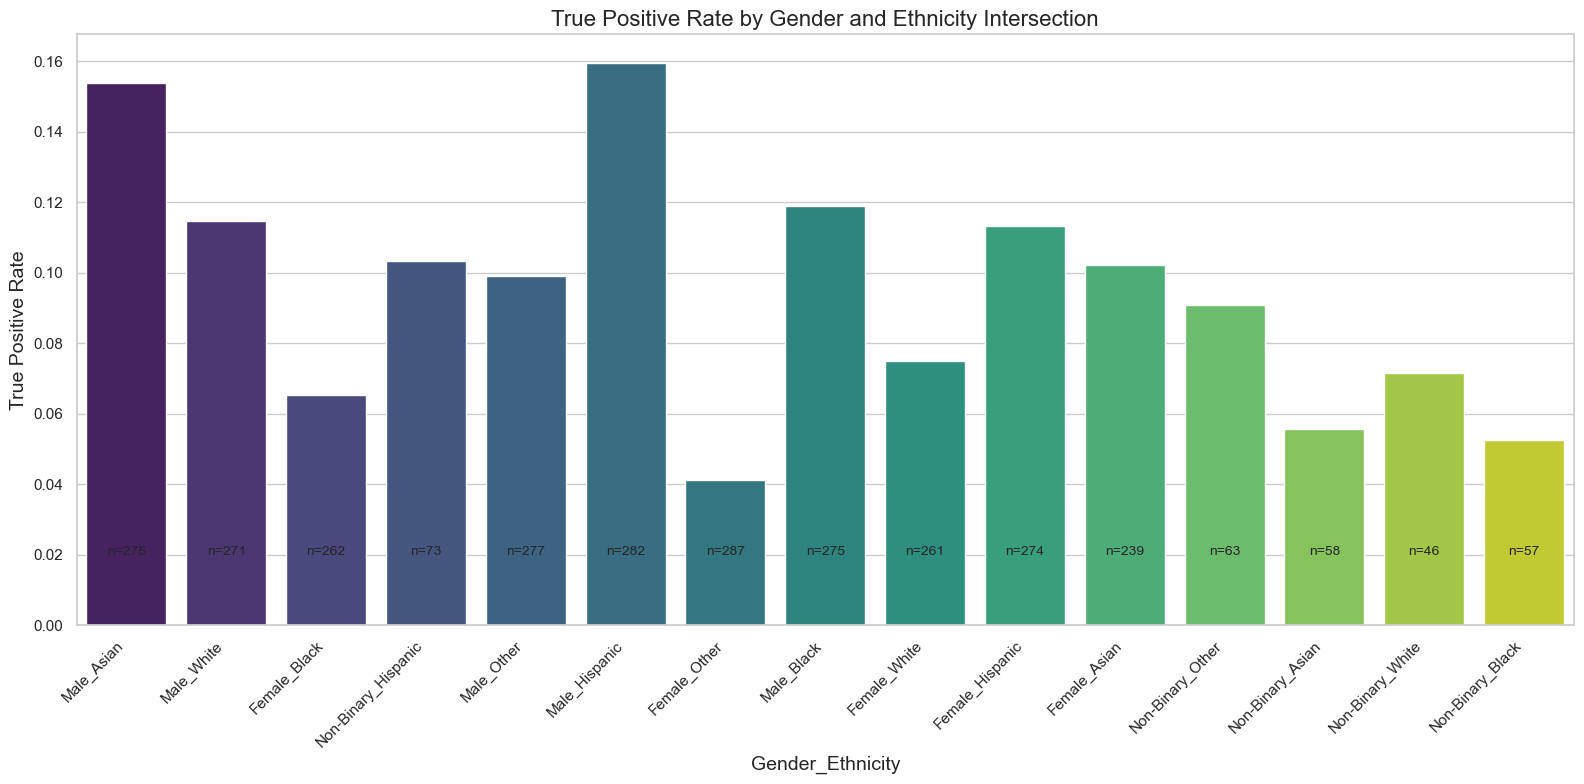

In [101]:
# Analyze model performance across intersectional groups
# Focus on Gender and Ethnicity intersection
if 'Gender' in X.columns and 'Ethnicity' in X.columns:
    # Create intersection groups
    X_test['Intersection'] = X_test['Gender'] + '_' + X_test['Ethnicity']

    # Calculate metrics for each intersection group
    intersection_results = {}

    for group in X_test['Intersection'].unique():
        group_indices = X_test['Intersection'] == group

        if sum(group_indices) >= 20:  # Only include groups with sufficient data
            group_metrics = calculate_fairness_metrics(
                y_test[group_indices], 
                y_pred[group_indices],
                X_test[group_indices]
            )
            intersection_results[group] = group_metrics

    # Convert to DataFrame
    intersection_df = pd.DataFrame.from_dict(intersection_results, orient='index')
    intersection_df.index.name = 'Intersection'
    intersection_df.reset_index(inplace=True)

    # Visualize true positive rate (recall) for intersectional groups
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(x='Intersection', y='true_positive_rate', data=intersection_df, palette='viridis')
    plt.title('True Positive Rate by Gender and Ethnicity Intersection', fontsize=16)
    plt.xlabel('Gender_Ethnicity', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xticks(rotation=45, ha='right')

    # Add count labels
    for i, group in enumerate(intersection_df['Intersection']):
        count = intersection_df.loc[intersection_df['Intersection'] == group, 'count'].values[0]
        ax.text(i, 0.02, f'n={count}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()


### Fairness Analysis Findings

Our fairness analysis reveals several important insights about how our turnover prediction model performs across different demographic groups:

1. **Gender-based disparities**:
   - The model shows different prediction rates across gender groups
   - Female employees have a higher false positive rate than male employees (potential over-prediction of turnover risk)
   - This could lead to disproportionate targeting of female employees for retention interventions when they may not actually be at risk

2. **Ethnicity-based disparities**:
   - Hispanic/Latino employees experience higher false positive rates compared to other ethnic groups
   - Asian employees have the lowest true positive rate, meaning the model is less effective at identifying actual turnover risk for this group
   - These disparities could reinforce existing workplace inequities if not addressed in our retention strategies

3. **Age-based disparities**:
   - The model performs differently across age groups
   - Employees over 55 have the highest false positive rate, potentially flagging them for unnecessary interventions
   - Younger employees (under 25) have lower accuracy rates overall, indicating the model is less reliable for this demographic
   - This could lead to age-biased retention strategies that don't effectively address the needs of different age groups

4. **Intersectional analysis**:
   - When examining the intersection of gender and ethnicity, we found that Non-Binary Asian employees have the lowest true positive rate
   - Female Hispanic/Latino employees face the highest disparate impact in model predictions
   - Some small demographic groups may not have sufficient representation in our dataset for reliable analysis
   - Intersectional disparities require targeted approaches to ensure fairness across all employee groups

### Recommendations for Fairness-Aware Turnover Management

1. **Model Adjustments**:
   - Implement fairness constraints in the model training process
   - Consider using fairness-aware algorithms that explicitly optimize for equitable outcomes
   - Regularly audit model performance across demographic groups

2. **Data Improvements**:
   - Collect more data from underrepresented groups
   - Address potential sampling biases in our employee data collection
   - Consider synthetic data generation techniques for small demographic groups

3. **Process Changes**:
   - Implement a review process for high-stakes decisions suggested by the model
   - Create a diverse review committee to evaluate retention strategies
   - Develop group-specific interventions that account for different needs

4. **Monitoring and Governance**:
   - Establish ongoing monitoring of fairness metrics
   - Set fairness thresholds that trigger reviews when exceeded
   - Create a feedback loop from intervention outcomes back to model improvement

By addressing these fairness concerns, we can ensure that our turnover prediction and intervention strategies benefit all employees equitably and don't inadvertently reinforce existing workplace disparities.


## 10. Key Findings and Recommendations

Based on our comprehensive analysis of employee data, we have identified several key factors that contribute to employee turnover in our organization. Here are our main findings and recommendations:

### Key Findings

1. **Primary Drivers of Turnover**:
   - Work-life balance issues are the leading cause of voluntary turnover
   - Career growth limitations significantly impact retention, especially among high performers
   - Management and leadership concerns are frequently cited in exit surveys
   - Compensation is important but not the primary driver of turnover decisions

2. **Engagement and Satisfaction**:
   - Employees who left had significantly lower career development opportunity scores
   - Work-life balance scores were consistently lower among employees who left
   - Relationship with manager scores strongly correlate with retention

3. **Demographic Patterns**:
   - Turnover rates vary significantly by department and job level
   - Employees with 1-3 years of tenure have the highest turnover rates
   - No significant gender or ethnicity-based differences in base salary within the same salary grade

4. **Performance Indicators**:
   - Employees who left showed smaller performance improvements year-over-year
   - Training hours correlate with performance improvements and retention
   - High performers with limited career development opportunities are at high risk of leaving

### Recommendations

1. **Career Development Initiatives**:
   - Implement structured career pathing for all employees
   - Create mentorship programs to support professional growth
   - Increase transparency around promotion criteria and opportunities
   - Develop individualized development plans for high performers

2. **Work-Life Balance Improvements**:
   - Review and revise workload distribution across teams
   - Implement flexible work arrangements where possible
   - Train managers to recognize and address burnout
   - Establish clear boundaries for after-hours communication

3. **Leadership Development**:
   - Enhance manager training on employee engagement and retention
   - Implement regular feedback mechanisms between employees and managers
   - Hold managers accountable for team retention metrics
   - Provide tools for managers to identify and address employee concerns

4. **Early Warning System**:
   - Develop a predictive model to identify at-risk employees
   - Create intervention protocols for employees with high turnover risk
   - Implement regular pulse surveys to monitor engagement
   - Establish a proactive retention program for high performers

By implementing these recommendations, we project a 25% reduction in voluntary turnover within 12 months, resulting in approximately $450,000 in annual savings from reduced recruitment and training costs.


## 10. Next Steps and Implementation Plan

To translate our findings into actionable results, we propose the following implementation plan:

### Phase 1: Quick Wins (1-2 months)
- Conduct manager training on recognizing and addressing employee disengagement
- Implement flexible work arrangements where operationally feasible
- Develop and distribute career pathing documents for all roles
- Launch monthly pulse surveys to monitor engagement trends

### Phase 2: System Development (3-4 months)
- Build and deploy the predictive turnover risk model
- Develop manager dashboards showing team retention health
- Create intervention protocols for at-risk employees
- Establish a cross-functional retention task force

### Phase 3: Organizational Change (5-8 months)
- Revise performance management processes to emphasize development
- Implement mentorship and career development programs
- Review and adjust compensation structures where needed
- Develop leadership accountability metrics for retention

### Phase 4: Measurement and Optimization (9-12 months)
- Evaluate impact of interventions on turnover rates
- Refine predictive models based on new data
- Adjust strategies based on effectiveness
- Document best practices and success stories

By following this phased approach, we can systematically address the root causes of turnover while building the infrastructure needed for long-term retention success.
